##**Install and import libraries**

In [ ]:
#!pip install tensorflow keras opencv-python
!pip install segmentation-models
!pip install torch torchvision
!pip install segmentation-models-pytorch
!pip install monai
!pip install SimpleITK
!pip install segmentation_models_pytorch
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import torch.nn as nn
import torch._utils
import torch.nn.functional as F
from torchvision.models.resnet import Bottleneck
import torchvision as tv
import torch as t
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50
import segmentation_models_pytorch as smp
from google.colab import drive
import SimpleITK as sitk
import monai
from monai.transforms import LoadImage, ScaleIntensityRange, EnsureType, Compose, Resize, EnsureChannelFirst, Compose, LoadImageD, EnsureChannelFirstD, ResizeD, ScaleIntensityD, RandFlipD, RandRotateD, RandZoomD, ToTensorD, RandShiftIntensityD, RandAdjustContrastD
from monai.data import CacheDataset, Dataset, DataLoader
from monai.networks.nets import UNet, DynUNet, SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.transforms import AsDiscrete, Activations
from monai.utils import set_determinism
from tqdm import tqdm
from monai.data.image_reader import PILReader
from torch.optim import Adam
import seaborn as sns

###Mount Drive and set paths

In [ ]:
#!fusermount -u "/content/drive"
#!rm -rf "/content/drive"
drive.mount("/content/drive/")
drive_path = "/content/drive/MyDrive/deplo_dataset/"

data_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG"
train_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/train/images"
#train_masks_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/train/masks"
validation_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/validation/images"
#validation_masks_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/validation/masks"
test_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/test/images"
#test_masks_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/test/masks"

# setting device so it will use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# variable that can be "globally" changed to resize the images' height and width accordingly
dimensions = 256

Mounted at /content/drive/


##Binary Masks

In [ ]:
# Directory containing the original mask images
mask_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/test/masks"
# Directory to save the binary masks
binary_mask_dir = "/content/drive/MyDrive/deplo_dataset/test_masks_binary"

# Ensure the output directory exists
os.makedirs(binary_mask_dir, exist_ok=True)

# Loop through each mask file in the mask directory
for mask_file in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_file)
    mask = sitk.ReadImage(mask_path)

    # Convert the mask to a numpy array
    mask_np = sitk.GetArrayFromImage(mask)

    # Print the shape of the original mask
    print(f"Original Mask Shape ({mask_file}): {mask_np.shape}")

    # Apply binary thresholding: set all non-zero values to 1
    binary_mask_np = (mask_np > 0).astype(np.uint8)

    # Ensure the binary mask has the correct shape
    if len(binary_mask_np.shape) > 2:
        binary_mask_np = np.squeeze(binary_mask_np)  # Remove channel dimension if necessary

    print(f"Binary Mask Shape ({mask_file}): {binary_mask_np.shape}")

    # Convert back to a SimpleITK image and save
    binary_mask = sitk.GetImageFromArray(binary_mask_np)
    binary_mask.CopyInformation(mask)

    binary_mask_path = os.path.join(binary_mask_dir, mask_file)
    sitk.WriteImage(binary_mask, binary_mask_path)
    print(f"Processed and saved binary mask: {binary_mask_path}\n")


Original Mask Shape (58.jpg): (352, 352)
Binary Mask Shape (58.jpg): (352, 352)
Processed and saved binary mask: /content/drive/MyDrive/deplo_dataset/test_masks_binary/58.jpg

Original Mask Shape (53.jpg): (352, 352)
Binary Mask Shape (53.jpg): (352, 352)
Processed and saved binary mask: /content/drive/MyDrive/deplo_dataset/test_masks_binary/53.jpg

Original Mask Shape (25.jpg): (352, 352)
Binary Mask Shape (25.jpg): (352, 352)
Processed and saved binary mask: /content/drive/MyDrive/deplo_dataset/test_masks_binary/25.jpg

Original Mask Shape (15.jpg): (352, 352)
Binary Mask Shape (15.jpg): (352, 352)
Processed and saved binary mask: /content/drive/MyDrive/deplo_dataset/test_masks_binary/15.jpg

Original Mask Shape (79.jpg): (352, 352)
Binary Mask Shape (79.jpg): (352, 352)
Processed and saved binary mask: /content/drive/MyDrive/deplo_dataset/test_masks_binary/79.jpg

Original Mask Shape (22.jpg): (352, 352)
Binary Mask Shape (22.jpg): (352, 352)
Processed and saved binary mask: /conten

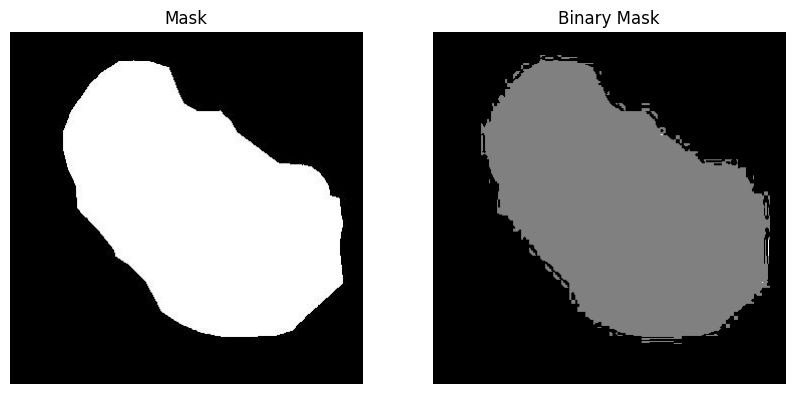

In [ ]:
# Function to visualize the binary mask
def visualize_mask(mask_path, binary_mask_path):
    # Load the image and mask
    image = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
    mask = sitk.GetArrayFromImage(sitk.ReadImage(binary_mask_path))

    # Plot the image and mask side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title("Mask")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Binary Mask")
    axs[1].axis('off')

    plt.show()

# Example of how to call the function
mask_path = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/validation/masks/62.jpg"  # Replace with actual image path
binary_mask_path = "/content/drive/MyDrive/deplo_dataset/validation_masks_binary/62.jpg"  # Replace with actual mask path

visualize_mask(mask_path, binary_mask_path)


##**Preprocessing**

In [ ]:
# Define dataset paths
train_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/train/images"
train_masks_dir = "/content/drive/MyDrive/deplo_dataset/masks_binary"
validation_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/validation/images"
validation_masks_dir = "/content/drive/MyDrive/deplo_dataset/validation_masks_binary"
test_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/test/images"
test_masks_dir = "/content/drive/MyDrive/deplo_dataset/test_masks_binary"

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=42)

# Define data transformations
train_transforms = Compose([
    LoadImageD(keys=["image", "mask"], reader=PILReader()),  # Load both images and masks
    EnsureChannelFirstD(keys=["image", "mask"]),  # Ensure both have channel dimension
    ResizeD(keys=['image', 'mask'], spatial_size=(256, 256)),  # Resize to 256x256
    ScaleIntensityD(keys="image"),  # Scale intensity for images
    RandFlipD(keys=["image", "mask"], prob=0.5, spatial_axis=0),  # Random horizontal flip
    RandFlipD(keys=["image", "mask"], prob=0.5, spatial_axis=1),  # Random vertical flip
    RandRotateD(keys=["image", "mask"], range_x=30, prob=0.5),  # Random rotation by 30 degrees
    RandZoomD(keys=["image", "mask"], min_zoom=0.8, max_zoom=1.2, prob=0.5),  # Random zoom
    RandShiftIntensityD(keys="image", offsets=0.1, prob=0.5),  # Random intensity shift for images
    RandAdjustContrastD(keys="image", gamma=(0.7, 1.5), prob=0.5),  # Random contrast adjustment
    ToTensorD(keys=["image", "mask"]),  # Convert to tensors
])

val_transforms = Compose([
    LoadImageD(keys=["image", "mask"], reader=PILReader()),  # Load both images and masks
    EnsureChannelFirstD(keys=["image", "mask"]),  # Ensure both have channel dimension
    ResizeD(keys=['image', 'mask'], spatial_size=(256, 256)),  # Resize to 256x256
    ScaleIntensityD(keys="image"),  # Scale intensity for images
    ToTensorD(keys=["image", "mask"]),  # Convert to tensors
])

# Get the image and mask filenames
train_images = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
train_masks = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir) if f.endswith('.jpg')])

validation_images = sorted([os.path.join(validation_images_dir, f) for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_masks = sorted([os.path.join(validation_masks_dir, f) for f in os.listdir(validation_masks_dir) if f.endswith('.jpg')])

test_images = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.jpg')])
test_masks = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir) if f.endswith('.jpg')])

# Create a list of dictionaries with paired image-mask data
train_data = [{"image": img, "mask": msk} for img, msk in zip(train_images, train_masks)]
validation_data = [{"image": img, "mask": msk} for img, msk in zip(validation_images, validation_masks)]
test_data = [{"image": img, "mask": msk} for img, msk in zip(test_images, test_masks)]

# Print the structure to verify
#print(train_data[0])  #first element of the dataset


# Use CacheDataset for faster access to frequently used data
train_dataset = Dataset(
    data=train_data,  # Paired image-mask data
    transform=train_transforms,  # Transformation pipeline # Cache the entire dataset (set lower for large datasets)
)

validation_dataset = Dataset(
    data=validation_data,  # Paired image-mask data
    transform=val_transforms,  # Transformation pipeline # Cache the entire dataset (set lower for large datasets)
)

test_dataset = Dataset(
    data=test_data,  # Paired image-mask data
    transform=val_transforms,
)

# Alternatively, use regular Dataset if caching is not required
# train_dataset = Dataset(data=train_data, transform=train_transforms)

# Create DataLoader
train_loader = DataLoader(
    train_dataset,  # Your dataset
    batch_size=8,  # Batch size (adjust according to your system's memory)
    shuffle=True,  # Shuffle the data at the start of each epoch
    num_workers=4  # Number of parallel workers to load data
)

val_loader = DataLoader(
    validation_dataset,  # Your dataset
    batch_size=8,  # Batch size (adjust according to your system's memory)
    shuffle=True,  # Shuffle the data at the start of each epoch
    num_workers=4  # Number of parallel workers to load data
)

test_loader = DataLoader(
    test_dataset,  # Your test dataset
    batch_size=8,  # Batch size
    shuffle=False,  # No need to shuffle test data
    num_workers=4  # Number of parallel workers to load data
)
'''
# Check shapes in the DataLoader
for batch_data in train_loader:
    print("Image shape:", batch_data["image"].shape)  # Expect [8, C, 256, 256]
    print("Label shape:", batch_data["mask"].shape)  # Expect [8, 1, 256, 256]
    break  # Only for the first batch


# Print to check DataLoader
for batch_data in val_loader:
    print("Image shape:", batch_data["image"].shape)
    print("Label shape:", batch_data["mask"].shape)
    break  # Print only the first batch


# Print to check DataLoader
for batch_data in test_loader:
    print("Image shape:", batch_data["image"].shape)
    print("Label shape:", batch_data["mask"].shape)
    break  # Print only the first batch
'''

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


'\n# Check shapes in the DataLoader\nfor batch_data in train_loader:\n    print("Image shape:", batch_data["image"].shape)  # Expect [8, C, 256, 256]\n    print("Label shape:", batch_data["mask"].shape)  # Expect [8, 1, 256, 256]\n    break  # Only for the first batch\n\n\n# Print to check DataLoader\nfor batch_data in val_loader:\n    print("Image shape:", batch_data["image"].shape)\n    print("Label shape:", batch_data["mask"].shape)\n    break  # Print only the first batch\n\n\n# Print to check DataLoader\nfor batch_data in test_loader:\n    print("Image shape:", batch_data["image"].shape)\n    print("Label shape:", batch_data["mask"].shape)\n    break  # Print only the first batch\n'

##**Metrics**

In [ ]:
'''loss_function = DiceLoss(sigmoid=True)

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Dice Metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean")'''

'loss_function = DiceLoss(sigmoid=True)\n\n# Optimizer: Adam\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-4)\n\n# Dice Metric for evaluation\ndice_metric = DiceMetric(include_background=False, reduction="mean")'

##**Training**

In [ ]:
'''loss_function = DiceLoss(sigmoid=True)

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Dice Metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean")'''

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#scheduler.step(avg_val_loss) #update this during validation


def training(model, model_save_dir, model_save_path):
  training_losses = []
  validation_losses = []
  validation_dice_scores = []

  val_interval = 2 #validate after training 2 epochs
  num_epochs = 200

  for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")

      model.train()  # Set the model to training mode
      epoch_loss = 0  # Track total loss for this epoch

      for batch_data in tqdm(train_loader):
          # Ensure proper handling of images and masks
          inputs = batch_data["image"].to(device)  # Move image tensor to device
          labels = batch_data["mask"].to(device)  # Move mask tensor to device

          optimizer.zero_grad()  # Zero out the gradients
          outputs = model(inputs)  # Forward pass
          loss = loss_function(outputs, labels)  # Compute loss

          loss.backward()  # Backpropagation
          optimizer.step()  # Update model weights

          epoch_loss += loss.item()  # Accumulate loss

      avg_train_loss = epoch_loss / len(train_loader)
      training_losses.append(avg_train_loss)
      print(f"Training loss: {avg_train_loss}")


      # Validation every `val_interval` epochs
      if (epoch + 1) % val_interval == 0:
          model.eval()  # Set the model to evaluation mode
          val_loss = 0
          dice_scores = []
          dice_metric.reset()  # Reset Dice metric

          with torch.no_grad():  # Disable gradient calculation
              for val_data in val_loader:
                  val_images = val_data["image"].to(device)
                  val_labels = val_data["mask"].to(device)

                  val_outputs = model(val_images)
                  #val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for binary segmentation
                  #val_outputs = (val_outputs > 0.5).float()  # Threshold the outputs

                  #calculate validation loss
                  loss = loss_function(val_outputs, val_labels)
                  val_loss += loss.item()

                  # Calculate Dice Score
                  val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for Dice metric
                  dice_score = dice_metric(y_pred=val_outputs, y=val_labels)
                  dice_scores.append(dice_score.mean().item())


              # Calculate average Dice score
              mean_dice_score = np.mean(dice_scores)
              print(f"Validation Mean Dice Score: {mean_dice_score}")
          # Track average validation loss and dice score (IoU)
          avg_val_loss = val_loss / len(val_loader)
          validation_losses.append(avg_val_loss)
          validation_dice_scores.append(mean_dice_score)
          print(f"Validation loss: {avg_val_loss}")
          print(f"Validation Mean Dice Score (IoU): {mean_dice_score}")

  torch.save(model.state_dict(), model_save_path)
  print(f"Model saved to {model_save_path}")

  epochs_range = range(1, num_epochs + 1)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, training_losses, label="Training Loss")
  plt.plot(range(2, num_epochs+1, val_interval), validation_losses, label="Validation Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot Validation Dice Score (IoU)
  plt.subplot(1, 2, 2)
  plt.plot(range(2, num_epochs+1, val_interval), validation_dice_scores, label="Validation Dice Score (IoU)", color='orange')
  plt.xlabel('Epochs')
  plt.ylabel('Dice Score (IoU)')
  plt.title('Validation Dice Score (IoU)')
  plt.legend()

  plt.tight_layout()
  plt.show()


  print("Training complete!")

##Training with new graphs for most models

In [ ]:
def training(model, model_save_dir, model_save_path):
    training_losses = []
    validation_losses = []
    validation_dice_scores = []
    validation_accuracies = []  # To track validation accuracies

    val_interval = 2  # Validate after every 2 epochs
    num_epochs = 200

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        model.train()  # Set the model to training mode
        epoch_loss = 0  # Track total loss for this epoch

        for batch_data in tqdm(train_loader):
            # Ensure proper handling of images and masks
            inputs = batch_data["image"].to(device)  # Move image tensor to device
            labels = batch_data["mask"].to(device)  # Move mask tensor to device

            optimizer.zero_grad()  # Zero out the gradients
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            epoch_loss += loss.item()  # Accumulate loss

        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss}")

        # Validation every `val_interval` epochs
        if (epoch + 1) % val_interval == 0:
            model.eval()  # Set the model to evaluation mode
            val_loss = 0
            dice_scores = []
            accuracies = []
            dice_metric.reset()  # Reset Dice metric

            with torch.no_grad():  # Disable gradient calculation
                for val_data in val_loader:
                    val_images = val_data["image"].to(device)
                    val_labels = val_data["mask"].to(device)

                    val_outputs = model(val_images)

                    # Calculate validation loss
                    loss = loss_function(val_outputs, val_labels)
                    val_loss += loss.item()

                    # Calculate Dice Score
                    val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for Dice metric
                    dice_score = dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_scores.append(dice_score.mean().item())

                    # Calculate accuracy
                    val_outputs_binary = (val_outputs > 0.5).float()  # Threshold outputs
                    correct = (val_outputs_binary == val_labels).float().sum()
                    total = torch.numel(val_labels)
                    accuracy = correct / total
                    accuracies.append(accuracy.item())

                # Calculate average Dice score and accuracy
                mean_dice_score = np.mean(dice_scores)
                mean_accuracy = np.mean(accuracies)
                print(f"Validation Mean Dice Score: {mean_dice_score}")
                print(f"Validation Accuracy: {mean_accuracy}")

            # Track average validation loss, Dice score, and accuracy
            avg_val_loss = val_loss / len(val_loader)
            validation_losses.append(avg_val_loss)
            validation_dice_scores.append(mean_dice_score)
            validation_accuracies.append(mean_accuracy)
            print(f"Validation loss: {avg_val_loss}")
            print(f"Validation Mean Dice Score (IoU): {mean_dice_score}")
            print(f"Validation Accuracy: {mean_accuracy}")

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Plot Training Loss, Validation Loss, Dice Score, and Accuracy
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label="Training Loss")
    plt.plot(range(2, num_epochs + 1, val_interval), validation_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Validation Dice Score (IoU) and Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(2, num_epochs + 1, val_interval), validation_dice_scores, label="Validation Dice Score (IoU)", color='orange')
    plt.plot(range(2, num_epochs + 1, val_interval), validation_accuracies, label="Validation Accuracy", color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Validation Dice Score (IoU) and Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training complete!")


##Training for DUCK Net


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def trainingduck(model, model_save_dir, model_save_path, train_dataset, val_dataset, batch_size=8, num_epochs=200):
    # Initialize lists to store losses and metrics
    training_losses = []
    validation_losses = []
    validation_dice_scores = []

    val_interval = 2  # Validate every 2 epochs

    # Create the optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss_function = DiceLoss(sigmoid=True)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        epoch_loss = 0  # Track total loss for this epoch

        # Iterate through training data
        for batch_data in tqdm(train_dataset, desc="Training..."):
            inputs = batch_data["image"]  # Assuming your dataset is a dictionary with image and mask keys
            labels = batch_data["mask"]

            with tf.GradientTape() as tape:
                outputs = model(inputs, training=True)  # Forward pass
                loss = loss_function(labels, outputs)  # Compute the loss

            # Compute gradients and update the model
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss += loss.numpy()  # Accumulate loss

        avg_train_loss = epoch_loss / len(train_dataset)
        training_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss}")

        # Validation every `val_interval` epochs
        if (epoch + 1) % val_interval == 0:
            model.evaluate(val_dataset, dice_metric, loss_function, validation_losses, validation_dice_scores)

    # Save the model after training
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Plot training and validation losses
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label="Training Loss")
    plt.plot(range(2, num_epochs + 1, val_interval), validation_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Validation Dice Score (IoU)
    plt.subplot(1, 2, 2)
    plt.plot(range(2, num_epochs + 1, val_interval), validation_dice_scores, label="Validation Dice Score (IoU)", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score (IoU)')
    plt.title('Validation Dice Score (IoU)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training complete!")


##Training for DeepLabv3

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def trainingdeeplab(model, model_save_dir, model_save_path, train_loader, val_loader, device):
    """
    Train a DeepLabV3 model using the given data loaders and configurations.

    Parameters:
        model: PyTorch model to be trained.
        model_save_dir (str): Directory to save the trained model.
        model_save_path (str): Full path to save the trained model file.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        device: Device to run the training (CPU/GPU).
    """
    # Initialize loss function, optimizer, and metric
    loss_function = DiceLoss(sigmoid=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    # Scheduler for learning rate adjustment
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Track metrics
    training_losses = []
    validation_losses = []
    validation_dice_scores = []

    # Training configuration
    val_interval = 2  # Validate every 2 epochs
    num_epochs = 200

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        epoch_loss = 0

        for batch_data in tqdm(train_loader, desc="Training", leave=False):
          inputs = batch_data["image"].to(device)
          labels = batch_data["mask"].to(device)

          optimizer.zero_grad()
          outputs = model(inputs)  # Forward pass
          outputs = outputs["out"]  # Extract the actual output tensor
          loss = loss_function(outputs, labels)  # Compute loss
          loss.backward()
          optimizer.step()


          epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss = 0
            dice_scores = []
            dice_metric.reset()

            with torch.no_grad():
              for val_data in tqdm(val_loader, desc="Validation", leave=False):
                  val_images = val_data["image"].to(device)
                  val_labels = val_data["mask"].to(device)

                  val_outputs = model(val_images)
                  val_outputs = val_outputs["out"]  # Extract the actual output tensor

                  loss = loss_function(val_outputs, val_labels)
                  val_loss += loss.item()

                  val_outputs = torch.sigmoid(val_outputs)
                  dice_score = dice_metric(y_pred=val_outputs, y=val_labels)
                  dice_scores.append(dice_score.mean().item())

            avg_val_loss = val_loss / len(val_loader)
            mean_dice_score = np.mean(dice_scores)
            validation_losses.append(avg_val_loss)
            validation_dice_scores.append(mean_dice_score)
            print(f"Validation loss: {avg_val_loss:.4f}")
            print(f"Validation Mean Dice Score (IoU): {mean_dice_score:.4f}")

            scheduler.step(avg_val_loss)  # Update learning rate scheduler

    # Save the trained model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    # Plot metrics
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label="Training Loss")
    plt.plot(range(val_interval, num_epochs + 1, val_interval), validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(val_interval, num_epochs + 1, val_interval), validation_dice_scores, label="Validation Dice Score (IoU)", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score (IoU)")
    plt.title("Validation Dice Score (IoU)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training complete!")


##**New Training** works for PSPNet

In [ ]:
def new_training(model, model_save_dir, model_save_path):
    training_losses = []
    validation_losses = []
    validation_dice_scores = []

    val_interval = 2  # Validate after training 2 epochs
    num_epochs = 200

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        model.train()  # Set the model to training mode
        epoch_loss = 0  # Initialize epoch loss at the beginning of each epoch

        for batch_data in tqdm(train_loader):
            inputs = batch_data["image"].to(device)  # Move image tensor to device
            labels = batch_data["mask"].to(device)  # Move mask tensor to device

            optimizer.zero_grad()  # Zero out the gradients
            outputs = model(inputs)  # Forward pass

            # Apply sigmoid to model outputs (since they are logits)
            outputs = torch.sigmoid(outputs)

            # Calculate the loss
            loss = loss_function(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            epoch_loss += loss.item()  # Accumulate loss

        avg_train_loss = epoch_loss / len(train_loader)  # Average training loss for the epoch
        training_losses.append(avg_train_loss)  # Append to the list of losses
        print(f"Training loss: {avg_train_loss}")

        # Validation every `val_interval` epochs
        if (epoch + 1) % val_interval == 0:
            model.eval()  # Set the model to evaluation mode
            val_loss = 0
            dice_scores = []
            with torch.no_grad():  # Disable gradient calculation
                for val_data in val_loader:
                    val_images = val_data["image"].to(device)
                    val_labels = val_data["mask"].to(device)

                    val_outputs = model(val_images)
                    val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for binary segmentation

                    # Validation loss calculation
                    loss = loss_function(val_outputs, val_labels)
                    val_loss += loss.item()

                    # Calculate Dice score
                    dice_score = dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_scores.append(dice_score.mean().item())

                avg_val_loss = val_loss / len(val_loader)
                avg_dice_score = np.mean(dice_scores)

                validation_losses.append(avg_val_loss)
                validation_dice_scores.append(avg_dice_score)
                print(f"Validation Loss: {avg_val_loss:.4f}")
                print(f"Validation Dice Score: {avg_dice_score:.4f}")

    torch.save(model.state_dict(), model_save_path)  # Save the trained model
    print(f"Model saved to {model_save_path}")

    # Now plot the results after training
    plot_training_progress(training_losses, validation_losses, validation_dice_scores, num_epochs, val_interval=val_interval)

In [ ]:
def plot_training_progress(training_losses, validation_losses, validation_dice_scores, num_epochs, val_interval=2):
    # Create the plots
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label="Training Loss", color='blue')
    plt.plot(range(2, num_epochs + 1, val_interval), validation_losses, label="Validation Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Validation Dice Score (IoU)
    plt.subplot(1, 2, 2)
    plt.plot(range(2, num_epochs + 1, val_interval), validation_dice_scores, label="Validation Dice Score (IoU)", color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score (IoU)')
    plt.title('Validation Dice Score (IoU)')
    plt.legend()

    plt.tight_layout()
    plt.show()

##New Training both for Keras and Pytorch

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from tensorflow.keras import optimizers

def new_new_training(model, model_save_dir, model_save_path, train_loader, val_loader, is_keras=False, learning_rate=1e-4):
    training_losses = []
    validation_losses = []
    validation_dice_scores = []

    val_interval = 2  # Validate after training 2 epochs
    num_epochs = 200

    if is_keras:
        # Keras optimizer with dynamic learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        loss_function = 'binary_crossentropy'  # Binary segmentation loss for Keras
        # Compile the Keras model here
        model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

        # Convert PyTorch DataLoader to TensorFlow Dataset
        train_tf_dataset = create_tf_dataset_from_pytorch(train_loader)
        val_tf_dataset = create_tf_dataset_from_pytorch(val_loader)

        # Train the Keras model
        model.fit(train_tf_dataset, epochs=num_epochs, validation_data=val_tf_dataset)
    else:
        # PyTorch optimizer with dynamic learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            epoch_loss = 0  # Initialize epoch loss at the beginning of each epoch

            # Training loop
            model.train()  # Set the model to training mode (this is for PyTorch)
            for batch_data in tqdm(train_loader):
                inputs = batch_data["image"].to(device)  # Move image tensor to device
                labels = batch_data["mask"].to(device)  # Move mask tensor to device

                optimizer.zero_grad()  # Zero out the gradients
                outputs = model(inputs)  # Forward pass

                # Apply sigmoid to model outputs (since they are logits)
                outputs = torch.sigmoid(outputs)

                # Calculate the loss
                loss = loss_function(outputs, labels)
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model weights

                epoch_loss += loss.item()  # Accumulate loss

            avg_train_loss = epoch_loss / len(train_loader)  # Average training loss for the epoch
            training_losses.append(avg_train_loss)  # Append to the list of losses
            print(f"Training loss: {avg_train_loss}")

            # Validation every `val_interval` epochs
            if (epoch + 1) % val_interval == 0:
                val_loss = 0
                dice_scores = []

                model.eval()  # Set the model to evaluation mode (this is for PyTorch)
                with torch.no_grad():  # Disable gradient calculation for PyTorch
                    for val_data in val_loader:
                        val_images = val_data["image"].to(device)
                        val_labels = val_data["mask"].to(device)

                        val_outputs = model(val_images)
                        val_outputs = torch.sigmoid(val_outputs)  # Apply sigmoid for binary segmentation

                        # Validation loss calculation
                        loss = loss_function(val_outputs, val_labels)
                        val_loss += loss.item()

                        # Calculate Dice score (you may need to adjust for Keras)
                        dice_score = dice_metric(y_pred=val_outputs, y=val_labels)
                        dice_scores.append(dice_score.mean().item())

                avg_val_loss = val_loss / len(val_loader)
                avg_dice_score = np.mean(dice_scores)

                validation_losses.append(avg_val_loss)
                validation_dice_scores.append(avg_dice_score)
                print(f"Validation Loss: {avg_val_loss:.4f}")
                print(f"Validation Dice Score: {avg_dice_score:.4f}")

        # For PyTorch, save the model after all epochs
        if not is_keras:
            torch.save(model.state_dict(), model_save_path)  # Save the trained model
            print(f"Model saved to {model_save_path}")

    # Now plot the results after training
    plot_training_progress(training_losses, validation_losses, validation_dice_scores, num_epochs, val_interval=val_interval)

##**Testing**

In [ ]:
def calculate_iou(pred, true):
    intersection = np.sum((pred > 0.5) * (true > 0.5))  # Area of overlap
    union = np.sum(pred > 0.5) + np.sum(true > 0.5) - intersection  # Area of union
    if union == 0:
        return 0  # Avoid division by zero
    return intersection / union  # Return IoU

def test_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["image"].to(device)  # Move image tensor to device
            masks = batch_data["mask"].to(device)  # Move mask tensor to device

            # Forward pass through the model
            outputs = model(images)

            # Convert outputs to binary masks (0 or 1)
            predicted_masks = torch.sigmoid(outputs)
            predicted_masks = (predicted_masks > 0.5).float()  # Threshold to create binary masks

            # Collect predictions and ground truths for metrics calculation
            all_preds.append(predicted_masks.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

    # Flatten the list of arrays
    all_preds = np.concatenate(all_preds, axis=0).flatten().astype(int)
    all_labels = np.concatenate(all_labels, axis=0).flatten().astype(int)

    # Calculate IoU
    ious = [calculate_iou(pred, true) for pred, true in zip(all_preds.reshape(-1, 1), all_labels.reshape(-1, 1))]
    avg_iou = np.mean(ious)
    print(f"Test Average IoU: {avg_iou:.4f}")

    # Calculate additional metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)  # Avoid division by zero
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plot_confusion_matrix(cm)

    return avg_iou, accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                #xticklabels=['Background', 'Foreground'],
                #yticklabels=['Background', 'Foreground']
                )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load the model weights

##testing new graph

In [ ]:
def calculate_iou(pred, true):
    intersection = np.sum((pred > 0.5) * (true > 0.5))  # Area of overlap
    union = np.sum(pred > 0.5) + np.sum(true > 0.5) - intersection  # Area of union
    if union == 0:
        return 0  # Avoid division by zero
    return intersection / union  # Return IoU

def test_model2(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    batch_accuracies = []  # Track accuracy per batch

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["image"].to(device)  # Move image tensor to device
            masks = batch_data["mask"].to(device)  # Move mask tensor to device

            # Forward pass through the model
            outputs = model(images)

            # Convert outputs to binary masks (0 or 1)
            predicted_masks = torch.sigmoid(outputs)
            predicted_masks = (predicted_masks > 0.5).float()  # Threshold to create binary masks

            # Collect predictions and ground truths for metrics calculation
            all_preds.append(predicted_masks.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

            # Batch accuracy
            batch_preds = predicted_masks.cpu().numpy().flatten().astype(int)
            batch_labels = masks.cpu().numpy().flatten().astype(int)
            batch_accuracy = accuracy_score(batch_labels, batch_preds)
            batch_accuracies.append(batch_accuracy)

    # Flatten the list of arrays
    all_preds = np.concatenate(all_preds, axis=0).flatten().astype(int)
    all_labels = np.concatenate(all_labels, axis=0).flatten().astype(int)

    # Calculate IoU
    ious = [calculate_iou(pred, true) for pred, true in zip(all_preds.reshape(-1, 1), all_labels.reshape(-1, 1))]
    avg_iou = np.mean(ious)
    print(f"Test Average IoU: {avg_iou:.4f}")

    # Calculate additional metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)  # Avoid division by zero
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot batch-wise accuracy
    plot_accuracy(batch_accuracies)

    # Plot confusion matrix
    plot_confusion_matrix(cm)

    return avg_iou, accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_accuracy(batch_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(batch_accuracies) + 1), batch_accuracies, marker='o', label="Batch Accuracy")
    plt.title('Batch-wise Accuracy During Testing')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()


##**UNet**

In [ ]:
# Define a U-Net model
model = UNet(
    spatial_dims=2,  # 2D U-Net
    in_channels=3,   # Single channel input (grayscale)
    out_channels=1,  # Binary segmentation
    channels=(64, 128, 256, 512, 1024),  # Number of features in each layer
    strides=(2, 2, 2, 2),  # Downsampling factors
    num_res_units=2  # Number of residual units
).to(device)

loss_function = DiceLoss(sigmoid=True)

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Dice Metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean")

model_save_dir = "/content/drive/MyDrive/deplo_dataset/unet/Dice"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_path = os.path.join(model_save_dir, "unet.pth")

training(model, model_save_dir, model_save_path)

Epoch 1/200


100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


Training loss: 0.773671748638153
Epoch 2/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.7630335974693299


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8354966090275691
Validation loss: 0.7569070275013263
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8354966090275691
Epoch 3/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Training loss: 0.7498120498657227
Epoch 4/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.73265251994133


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8427970592792218
Validation loss: 0.7248921761145959
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8427970592792218
Epoch 5/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.7183647322654724
Epoch 6/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.705251972079277


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8482513427734375
Validation loss: 0.6987011982844427
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8482513427734375
Epoch 7/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.6927600675821304
Epoch 8/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.6840031903982162
Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8507986802321214
Validation loss: 0.6721634956506582
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8507986802321214
Epoch 9/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.675693821310997
Epoch 10/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.666412690281868


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8714000995342548
Validation loss: 0.6592801534212552
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8714000995342548
Epoch 11/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.6576124858856202
Epoch 12/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.6522758108377457


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8743779109074519
Validation loss: 0.6477721562752357
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8743779109074519
Epoch 13/200


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Training loss: 0.6461024683713913
Epoch 14/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.6380549508333206


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8704272050123948
Validation loss: 0.6322315014325656
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8704272050123948
Epoch 15/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.6304969161748886
Epoch 16/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.6258296445012093


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8654460906982422
Validation loss: 0.6260967117089492
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8654460906982422
Epoch 17/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.6210887911915779
Epoch 18/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.6153925544023514


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8957041226900541
Validation loss: 0.6122472102825458
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8957041226900541
Epoch 19/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.6080594447255134
Epoch 20/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Training loss: 0.6022800767421722


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8889904022216797
Validation loss: 0.6002600811994993
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8889904022216797
Epoch 21/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.5968880033493043
Epoch 22/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.5909154087305069


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8993062239426833
Validation loss: 0.5881579564167903
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8993062239426833
Epoch 23/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Training loss: 0.5853816655278206
Epoch 24/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]

Training loss: 0.5767699709534645


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8795773432804987
Validation loss: 0.5819993408826681
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8795773432804987
Epoch 25/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.5752946922183036
Epoch 26/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.5662118178606034


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8788513770470252
Validation loss: 0.5692667158750387
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8788513770470252
Epoch 27/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.5623218700289726
Epoch 28/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.5583806890249252


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.885136971106896
Validation loss: 0.5633645745424124
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.885136971106896
Epoch 29/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.5524724239110946
Epoch 30/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.5424018821120262


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.9029407501220703
Validation loss: 0.5439334351282853
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.9029407501220703
Epoch 31/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.5395286738872528
Epoch 32/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.5357054927945137


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8936358231764573
Validation loss: 0.5462756432019747
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8936358231764573
Epoch 33/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Training loss: 0.5264461812376976
Epoch 34/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.5230422040820122


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.869610859797551
Validation loss: 0.5216640188143804
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.869610859797551
Epoch 35/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.51408914655447
Epoch 36/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.5104588285088539


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.8961511758657602
Validation loss: 0.5171882647734422
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.8961511758657602
Epoch 37/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.50562132447958
Epoch 38/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.4959608921408653


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.9048117124117337
Validation loss: 0.5011341457183545
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.9048117124117337
Epoch 39/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.4952133318781853
Epoch 40/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.4873143258690834


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.9030323028564453
Validation loss: 0.4810606080752153
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.9030323028564453
Epoch 41/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.47997748106718063
Epoch 42/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.4735411447286606


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.905678969163161
Validation loss: 0.4752288071008829
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.905678969163161
Epoch 43/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.4656065410375595
Epoch 44/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.4599539789557457


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.9003203465388372
Validation loss: 0.4663739869227776
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.9003203465388372
Epoch 45/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.45389644950628283
Epoch 46/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.4472088479995728


Validation Mean Dice Score: 0.0
Validation Accuracy: 0.9034837576059195
Validation loss: 0.46321476422823393
Validation Mean Dice Score (IoU): 0.0
Validation Accuracy: 0.9034837576059195
Epoch 47/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.44572322100400924
Epoch 48/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.4331808964908123


Validation Mean Dice Score: 0.008138973530059537
Validation Accuracy: 0.9198979597825271
Validation loss: 0.4440532693496117
Validation Mean Dice Score (IoU): 0.008138973530059537
Validation Accuracy: 0.9198979597825271
Epoch 49/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.4286503957211971
Epoch 50/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.4290990164875984


Validation Mean Dice Score: 0.004036512225866318
Validation Accuracy: 0.911652344923753
Validation loss: 0.44293404542482817
Validation Mean Dice Score (IoU): 0.004036512225866318
Validation Accuracy: 0.911652344923753
Epoch 51/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.4205817802250385
Epoch 52/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.4171695563197136


Validation Mean Dice Score: 0.00969087525915641
Validation Accuracy: 0.9185857039231521
Validation loss: 0.41796393577869123
Validation Mean Dice Score (IoU): 0.00969087525915641
Validation Accuracy: 0.9185857039231521
Epoch 53/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.4060469380021095
Epoch 54/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.40266165643930435


Validation Mean Dice Score: 0.03255229824795746
Validation Accuracy: 0.9243950477013221
Validation loss: 0.39246744032089526
Validation Mean Dice Score (IoU): 0.03255229824795746
Validation Accuracy: 0.9243950477013221
Epoch 55/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.3971641404926777
Epoch 56/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.393582361638546


Validation Mean Dice Score: 0.021221773081029262
Validation Accuracy: 0.9204861567570612
Validation loss: 0.4003916634963109
Validation Mean Dice Score (IoU): 0.021221773081029262
Validation Accuracy: 0.9204861567570612
Epoch 57/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.39124465093016625
Epoch 58/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.38545689478516576


Validation Mean Dice Score: 0.03503358364552976
Validation Accuracy: 0.9198350172776443
Validation loss: 0.38718555294550383
Validation Mean Dice Score (IoU): 0.03503358364552976
Validation Accuracy: 0.9198350172776443
Epoch 59/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.3780007514357567
Epoch 60/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.3720015665888786


Validation Mean Dice Score: 0.05817205989016937
Validation Accuracy: 0.9274658790001502
Validation loss: 0.37507216746990496
Validation Mean Dice Score (IoU): 0.05817205989016937
Validation Accuracy: 0.9274658790001502
Epoch 61/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.36147302746772764
Epoch 62/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.35982584074139595


Validation Mean Dice Score: 0.06694003717543986
Validation Accuracy: 0.9203612987811749
Validation loss: 0.36845138325141025
Validation Mean Dice Score (IoU): 0.06694003717543986
Validation Accuracy: 0.9203612987811749
Epoch 63/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.3533084227144718
Epoch 64/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.34703829020261767


Validation Mean Dice Score: 0.12672392757052037
Validation Accuracy: 0.9206672081580529
Validation loss: 0.3580819540298902
Validation Mean Dice Score (IoU): 0.12672392757052037
Validation Accuracy: 0.9206672081580529
Epoch 65/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Training loss: 0.34226758882403374
Epoch 66/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.3407211318612099


Validation Mean Dice Score: 0.10878718921986337
Validation Accuracy: 0.9234237670898438
Validation loss: 0.3477009844321471
Validation Mean Dice Score (IoU): 0.10878718921986337
Validation Accuracy: 0.9234237670898438
Epoch 67/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.3341020917892456
Epoch 68/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.3263285382091999


Validation Mean Dice Score: 0.21556764096021652
Validation Accuracy: 0.9256641681377704
Validation loss: 0.34947861845676714
Validation Mean Dice Score (IoU): 0.21556764096021652
Validation Accuracy: 0.9256641681377704
Epoch 69/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.32262029260396957
Epoch 70/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.3136851434409618


Validation Mean Dice Score: 0.22926070985312647
Validation Accuracy: 0.9280652266282302
Validation loss: 0.3307370589329646
Validation Mean Dice Score (IoU): 0.22926070985312647
Validation Accuracy: 0.9280652266282302
Epoch 71/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.3170618087053299
Epoch 72/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.310714118629694


Validation Mean Dice Score: 0.24866436472019324
Validation Accuracy: 0.9264158102182242
Validation loss: 0.3338794307066844
Validation Mean Dice Score (IoU): 0.24866436472019324
Validation Accuracy: 0.9264158102182242
Epoch 73/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.303679663091898
Epoch 74/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.30067733734846114


Validation Mean Dice Score: 0.23387609559218758
Validation Accuracy: 0.9303848560039814
Validation loss: 0.30952887810193574
Validation Mean Dice Score (IoU): 0.23387609559218758
Validation Accuracy: 0.9303848560039814
Epoch 75/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.2955242605507374
Epoch 76/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.28748146794736384


Validation Mean Dice Score: 0.27653980993020993
Validation Accuracy: 0.9273044879619892
Validation loss: 0.3116731093480037
Validation Mean Dice Score (IoU): 0.27653980993020993
Validation Accuracy: 0.9273044879619892
Epoch 77/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.29559088543057443
Epoch 78/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.2868849308788776


Validation Mean Dice Score: 0.3283425850363878
Validation Accuracy: 0.928428943340595
Validation loss: 0.31456059561325955
Validation Mean Dice Score (IoU): 0.3283425850363878
Validation Accuracy: 0.928428943340595
Epoch 79/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.2821664573252201
Epoch 80/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.2768877722322941


Validation Mean Dice Score: 0.3447922342098676
Validation Accuracy: 0.9300518035888672
Validation loss: 0.3141977328520555
Validation Mean Dice Score (IoU): 0.3447922342098676
Validation Accuracy: 0.9300518035888672
Epoch 81/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.2783414601534605
Epoch 82/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Training loss: 0.2691114819049835


Validation Mean Dice Score: 0.37407456796902877
Validation Accuracy: 0.926292712871845
Validation loss: 0.311099478831658
Validation Mean Dice Score (IoU): 0.37407456796902877
Validation Accuracy: 0.926292712871845
Epoch 83/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.2682954277098179
Epoch 84/200


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

Training loss: 0.2666424056887627


Validation Mean Dice Score: 0.3910265931716332
Validation Accuracy: 0.9300823211669922
Validation loss: 0.2868638210571729
Validation Mean Dice Score (IoU): 0.3910265931716332
Validation Accuracy: 0.9300823211669922
Epoch 85/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.26385391406714914
Epoch 86/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

Training loss: 0.25471625819802285


Validation Mean Dice Score: 0.40905447189624494
Validation Accuracy: 0.9379753699669471
Validation loss: 0.27447570631137264
Validation Mean Dice Score (IoU): 0.40905447189624494
Validation Accuracy: 0.9379753699669471
Epoch 87/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.2546340973675251
Epoch 88/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.25123222716152666


Validation Mean Dice Score: 0.4009498885044685
Validation Accuracy: 0.9241965367243841
Validation loss: 0.2910219866495866
Validation Mean Dice Score (IoU): 0.4009498885044685
Validation Accuracy: 0.9241965367243841
Epoch 89/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.2509986262023449
Epoch 90/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.24206029929220677


Validation Mean Dice Score: 0.4597841077125989
Validation Accuracy: 0.93719849219689
Validation loss: 0.2718966110394551
Validation Mean Dice Score (IoU): 0.4597841077125989
Validation Accuracy: 0.93719849219689
Epoch 91/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Training loss: 0.24550916701555253
Epoch 92/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]

Training loss: 0.23461393505334854


Validation Mean Dice Score: 0.5087485393652549
Validation Accuracy: 0.9391931387094351
Validation loss: 0.2627478688955307
Validation Mean Dice Score (IoU): 0.5087485393652549
Validation Accuracy: 0.9391931387094351
Epoch 93/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.225461191162467
Epoch 94/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.22822896391153336


Validation Mean Dice Score: 0.45930870505085647
Validation Accuracy: 0.9383434882530799
Validation loss: 0.24734695599629328
Validation Mean Dice Score (IoU): 0.45930870505085647
Validation Accuracy: 0.9383434882530799
Epoch 95/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.2328632188588381
Epoch 96/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.2242517477273941


Validation Mean Dice Score: 0.4989582139712114
Validation Accuracy: 0.9379494006817157
Validation loss: 0.2419281258032872
Validation Mean Dice Score (IoU): 0.4989582139712114
Validation Accuracy: 0.9379494006817157
Epoch 97/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.22576267801225186
Epoch 98/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]

Training loss: 0.22208612456917762


Validation Mean Dice Score: 0.5432550654961512
Validation Accuracy: 0.9407216585599459
Validation loss: 0.24166401762228745
Validation Mean Dice Score (IoU): 0.5432550654961512
Validation Accuracy: 0.9407216585599459
Epoch 99/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.22334406077861785
Epoch 100/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.21740730732679367


Validation Mean Dice Score: 0.5335882145624894
Validation Accuracy: 0.9385824937086839
Validation loss: 0.24212934649907625
Validation Mean Dice Score (IoU): 0.5335882145624894
Validation Accuracy: 0.9385824937086839
Epoch 101/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.21634001433849334
Epoch 102/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.20744266137480735


Validation Mean Dice Score: 0.5526229097292974
Validation Accuracy: 0.9416032937856821
Validation loss: 0.23437352363879865
Validation Mean Dice Score (IoU): 0.5526229097292974
Validation Accuracy: 0.9416032937856821
Epoch 103/200


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Training loss: 0.20656476072967053
Epoch 104/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.20560981094837188


Validation Mean Dice Score: 0.5559190099055951
Validation Accuracy: 0.9322122427133414
Validation loss: 0.2484173419383856
Validation Mean Dice Score (IoU): 0.5559190099055951
Validation Accuracy: 0.9322122427133414
Epoch 105/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.20340826712548732
Epoch 106/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.20367844328284263


Validation Mean Dice Score: 0.5964571627286764
Validation Accuracy: 0.9358923985407903
Validation loss: 0.2360358490393712
Validation Mean Dice Score (IoU): 0.5964571627286764
Validation Accuracy: 0.9358923985407903
Epoch 107/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.20333586297929288
Epoch 108/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.2034020556509495


Validation Mean Dice Score: 0.5838122826356155
Validation Accuracy: 0.9338101607102615
Validation loss: 0.23365693023571601
Validation Mean Dice Score (IoU): 0.5838122826356155
Validation Accuracy: 0.9338101607102615
Epoch 109/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.1941105905920267
Epoch 110/200


100%|██████████| 100/100 [00:44<00:00,  2.22it/s]

Training loss: 0.19581894092261792


Validation Mean Dice Score: 0.5870711001066061
Validation Accuracy: 0.9432151500995343
Validation loss: 0.22173202267059913
Validation Mean Dice Score (IoU): 0.5870711001066061
Validation Accuracy: 0.9432151500995343
Epoch 111/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.18704569838941099
Epoch 112/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.1841592288762331


Validation Mean Dice Score: 0.5745781728854547
Validation Accuracy: 0.942140139066256
Validation loss: 0.2076604308990332
Validation Mean Dice Score (IoU): 0.5745781728854547
Validation Accuracy: 0.942140139066256
Epoch 113/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.18323851563036442
Epoch 114/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.18137833148241042


Validation Mean Dice Score: 0.5974276936971225
Validation Accuracy: 0.9377414996807392
Validation loss: 0.21304008593926063
Validation Mean Dice Score (IoU): 0.5974276936971225
Validation Accuracy: 0.9377414996807392
Epoch 115/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.1795299030095339
Epoch 116/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.18017960339784622


Validation Mean Dice Score: 0.5936386126738328
Validation Accuracy: 0.9404255793644831
Validation loss: 0.21217457033120668
Validation Mean Dice Score (IoU): 0.5936386126738328
Validation Accuracy: 0.9404255793644831
Epoch 117/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.1802133546024561
Epoch 118/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.18079988814890385


Validation Mean Dice Score: 0.6219238524253552
Validation Accuracy: 0.94055542579064
Validation loss: 0.20023801980110315
Validation Mean Dice Score (IoU): 0.6219238524253552
Validation Accuracy: 0.94055542579064
Epoch 119/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.1753826294839382
Epoch 120/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.17649172954261302


Validation Mean Dice Score: 0.6398616089270666
Validation Accuracy: 0.9417192018949069
Validation loss: 0.20563723146915436
Validation Mean Dice Score (IoU): 0.6398616089270666
Validation Accuracy: 0.9417192018949069
Epoch 121/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.17343813739717007
Epoch 122/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.16983143121004105


Validation Mean Dice Score: 0.6274562799013578
Validation Accuracy: 0.942517353938176
Validation loss: 0.19806911337834138
Validation Mean Dice Score (IoU): 0.6274562799013578
Validation Accuracy: 0.942517353938176
Epoch 123/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.16773252718150616
Epoch 124/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.16244269482791424


Validation Mean Dice Score: 0.6505771691982563
Validation Accuracy: 0.9425684121938852
Validation loss: 0.19772427529096603
Validation Mean Dice Score (IoU): 0.6505771691982563
Validation Accuracy: 0.9425684121938852
Epoch 125/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.16827446714043617
Epoch 126/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.16198028542101384


Validation Mean Dice Score: 0.6208555652545049
Validation Accuracy: 0.9354647122896634
Validation loss: 0.20877671069823778
Validation Mean Dice Score (IoU): 0.6208555652545049
Validation Accuracy: 0.9354647122896634
Epoch 127/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.16260045319795607
Epoch 128/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.15754166185855867


Validation Mean Dice Score: 0.6233257467930133
Validation Accuracy: 0.9386432354266827
Validation loss: 0.1906741656936132
Validation Mean Dice Score (IoU): 0.6233257467930133
Validation Accuracy: 0.9386432354266827
Epoch 129/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.15589440815150737
Epoch 130/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1596675945073366


Validation Mean Dice Score: 0.6424998251291422
Validation Accuracy: 0.9390257321871244
Validation loss: 0.19269528583838388
Validation Mean Dice Score (IoU): 0.6424998251291422
Validation Accuracy: 0.9390257321871244
Epoch 131/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.15652692072093488
Epoch 132/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.15465483538806438


Validation Mean Dice Score: 0.6837004377291753
Validation Accuracy: 0.9428646381084735
Validation loss: 0.18717587624604887
Validation Mean Dice Score (IoU): 0.6837004377291753
Validation Accuracy: 0.9428646381084735
Epoch 133/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.16064664863049985
Epoch 134/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.15456608526408672


Validation Mean Dice Score: 0.6700087029200333
Validation Accuracy: 0.9432309957650992
Validation loss: 0.17970846134882706
Validation Mean Dice Score (IoU): 0.6700087029200333
Validation Accuracy: 0.9432309957650992
Epoch 135/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.14611088432371616
Epoch 136/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.14368123434484004


Validation Mean Dice Score: 0.6114587394090799
Validation Accuracy: 0.9382428389329177
Validation loss: 0.18740356255036134
Validation Mean Dice Score (IoU): 0.6114587394090799
Validation Accuracy: 0.9382428389329177
Epoch 137/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.14793549865484237
Epoch 138/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.14506247617304324


Validation Mean Dice Score: 0.6117081596301153
Validation Accuracy: 0.9329775296724759
Validation loss: 0.20092469224563012
Validation Mean Dice Score (IoU): 0.6117081596301153
Validation Accuracy: 0.9329775296724759
Epoch 139/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.15042393058538436
Epoch 140/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.1438204650580883


Validation Mean Dice Score: 0.5975513458251953
Validation Accuracy: 0.9447473379281851
Validation loss: 0.17091929740630663
Validation Mean Dice Score (IoU): 0.5975513458251953
Validation Accuracy: 0.9447473379281851
Epoch 141/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1389193969964981
Epoch 142/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.14072129733860492


Validation Mean Dice Score: 0.6277566987734574
Validation Accuracy: 0.9408699915959284
Validation loss: 0.16573410366590208
Validation Mean Dice Score (IoU): 0.6277566987734574
Validation Accuracy: 0.9408699915959284
Epoch 143/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.13222764536738396
Epoch 144/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.13069514162838458


Validation Mean Dice Score: 0.6565118477894709
Validation Accuracy: 0.9401198167067307
Validation loss: 0.18079592746037704
Validation Mean Dice Score (IoU): 0.6565118477894709
Validation Accuracy: 0.9401198167067307
Epoch 145/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.14266180120408534
Epoch 146/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.13662763103842734


Validation Mean Dice Score: 0.6238549099518702
Validation Accuracy: 0.9456787109375
Validation loss: 0.1657005353615834
Validation Mean Dice Score (IoU): 0.6238549099518702
Validation Accuracy: 0.9456787109375
Epoch 147/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.13826345205307006
Epoch 148/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.12094807095825671


Validation Mean Dice Score: 0.6404126194807199
Validation Accuracy: 0.941773194533128
Validation loss: 0.1682293088390277
Validation Mean Dice Score (IoU): 0.6404126194807199
Validation Accuracy: 0.941773194533128
Epoch 149/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training loss: 0.1353317029774189
Epoch 150/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.13112835854291915


Validation Mean Dice Score: 0.6406752650554364
Validation Accuracy: 0.9399453676663913
Validation loss: 0.19320239814428183
Validation Mean Dice Score (IoU): 0.6406752650554364
Validation Accuracy: 0.9399453676663913
Epoch 151/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.12969612635672093
Epoch 152/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.12899997547268868


Validation Mean Dice Score: 0.6446742552977341
Validation Accuracy: 0.943303475013146
Validation loss: 0.15607397888715452
Validation Mean Dice Score (IoU): 0.6446742552977341
Validation Accuracy: 0.943303475013146
Epoch 153/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.1297703976929188
Epoch 154/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.12571381263434886


Validation Mean Dice Score: 0.6256147095790277
Validation Accuracy: 0.9396795126108023
Validation loss: 0.1701520916361075
Validation Mean Dice Score (IoU): 0.6256147095790277
Validation Accuracy: 0.9396795126108023
Epoch 155/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.13049459531903268
Epoch 156/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.12136033318936824


Validation Mean Dice Score: 0.6894933810600867
Validation Accuracy: 0.9453472724327674
Validation loss: 0.15541823036395586
Validation Mean Dice Score (IoU): 0.6894933810600867
Validation Accuracy: 0.9453472724327674
Epoch 157/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.13126231782138348
Epoch 158/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.12241984143853188


Validation Mean Dice Score: 0.6560991543989915
Validation Accuracy: 0.939902085524339
Validation loss: 0.16546211105126601
Validation Mean Dice Score (IoU): 0.6560991543989915
Validation Accuracy: 0.939902085524339
Epoch 159/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1225285879522562
Epoch 160/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.12219465591013431


Validation Mean Dice Score: 0.6719648838043213
Validation Accuracy: 0.9425797095665565
Validation loss: 0.1604749056009146
Validation Mean Dice Score (IoU): 0.6719648838043213
Validation Accuracy: 0.9425797095665565
Epoch 161/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.12211021713912487
Epoch 162/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.13069944471120834


Validation Mean Dice Score: 0.6881008652540354
Validation Accuracy: 0.944607661320613
Validation loss: 0.15602186494148695
Validation Mean Dice Score (IoU): 0.6881008652540354
Validation Accuracy: 0.944607661320613
Epoch 163/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.11921386934816837
Epoch 164/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.11835143268108368


Validation Mean Dice Score: 0.6605103290998019
Validation Accuracy: 0.9432845482459435
Validation loss: 0.15534963516088632
Validation Mean Dice Score (IoU): 0.6605103290998019
Validation Accuracy: 0.9432845482459435
Epoch 165/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.12079946011304855
Epoch 166/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.12294986106455326


Validation Mean Dice Score: 0.661827591749338
Validation Accuracy: 0.9465236663818359
Validation loss: 0.15566084533929825
Validation Mean Dice Score (IoU): 0.661827591749338
Validation Accuracy: 0.9465236663818359
Epoch 167/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.11877697184681893
Epoch 168/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.11736244134604931


Validation Mean Dice Score: 0.675050132549726
Validation Accuracy: 0.9387318537785456
Validation loss: 0.1633625328540802
Validation Mean Dice Score (IoU): 0.675050132549726
Validation Accuracy: 0.9387318537785456
Epoch 169/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Training loss: 0.11962393894791604
Epoch 170/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.12977625869214535


Validation Mean Dice Score: 0.6323852378588456
Validation Accuracy: 0.9372910719651443
Validation loss: 0.16534694341512826
Validation Mean Dice Score (IoU): 0.6323852378588456
Validation Accuracy: 0.9372910719651443
Epoch 171/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.12379578731954098
Epoch 172/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.121816131696105


Validation Mean Dice Score: 0.6835859555464524
Validation Accuracy: 0.9430631490854117
Validation loss: 0.164104720720878
Validation Mean Dice Score (IoU): 0.6835859555464524
Validation Accuracy: 0.9430631490854117
Epoch 173/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training loss: 0.11395997367799282
Epoch 174/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.11442783989012241


Validation Mean Dice Score: 0.6709787891461299
Validation Accuracy: 0.9361519446739783
Validation loss: 0.1514483610024819
Validation Mean Dice Score (IoU): 0.6709787891461299
Validation Accuracy: 0.9361519446739783
Epoch 175/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1261097864806652
Epoch 176/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Training loss: 0.12393174104392529


Validation Mean Dice Score: 0.6780701692287738
Validation Accuracy: 0.9343495002159705
Validation loss: 0.1650933279440953
Validation Mean Dice Score (IoU): 0.6780701692287738
Validation Accuracy: 0.9343495002159705
Epoch 177/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.11279001742601395
Epoch 178/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.11296670891344547


Validation Mean Dice Score: 0.6915619602570167
Validation Accuracy: 0.9442204695481521
Validation loss: 0.15392373616878802
Validation Mean Dice Score (IoU): 0.6915619602570167
Validation Accuracy: 0.9442204695481521
Epoch 179/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.11424563750624657
Epoch 180/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.11597343936562537


Validation Mean Dice Score: 0.7211914612696722
Validation Accuracy: 0.942042717566857
Validation loss: 0.15127347295100874
Validation Mean Dice Score (IoU): 0.7211914612696722
Validation Accuracy: 0.942042717566857
Epoch 181/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.11412168771028519
Epoch 182/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.11134907625615596


Validation Mean Dice Score: 0.707188789661114
Validation Accuracy: 0.9401000096247747
Validation loss: 0.16765554249286652
Validation Mean Dice Score (IoU): 0.707188789661114
Validation Accuracy: 0.9401000096247747
Epoch 183/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.11149778500199319
Epoch 184/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.11743520192801953


Validation Mean Dice Score: 0.7173430644548856
Validation Accuracy: 0.9475555419921875
Validation loss: 0.15099704150970167
Validation Mean Dice Score (IoU): 0.7173430644548856
Validation Accuracy: 0.9475555419921875
Epoch 185/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.1089879847317934
Epoch 186/200


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]

Training loss: 0.10452588237822055


Validation Mean Dice Score: 0.7085575232139001
Validation Accuracy: 0.9392224825345553
Validation loss: 0.16770612047268793
Validation Mean Dice Score (IoU): 0.7085575232139001
Validation Accuracy: 0.9392224825345553
Epoch 187/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.1123291339725256
Epoch 188/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.11215948686003685


Validation Mean Dice Score: 0.6905740407797006
Validation Accuracy: 0.9336346846360427
Validation loss: 0.17963087444122022
Validation Mean Dice Score (IoU): 0.6905740407797006
Validation Accuracy: 0.9336346846360427
Epoch 189/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.10999661915004254
Epoch 190/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.1145718303322792


Validation Mean Dice Score: 0.7057100832462311
Validation Accuracy: 0.9338562305157001
Validation loss: 0.1872144782772431
Validation Mean Dice Score (IoU): 0.7057100832462311
Validation Accuracy: 0.9338562305157001
Epoch 191/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.11176921874284744
Epoch 192/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.10617534935474396


Validation Mean Dice Score: 0.6906276345252991
Validation Accuracy: 0.9402983738825872
Validation loss: 0.1722419926753411
Validation Mean Dice Score (IoU): 0.6906276345252991
Validation Accuracy: 0.9402983738825872
Epoch 193/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.10232441052794457
Epoch 194/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.11101682424545288


Validation Mean Dice Score: 0.6953623845027044
Validation Accuracy: 0.9467808650090144
Validation loss: 0.1539173899934842
Validation Mean Dice Score (IoU): 0.6953623845027044
Validation Accuracy: 0.9467808650090144
Epoch 195/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.11221144035458565
Epoch 196/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.10333173535764217


Validation Mean Dice Score: 0.7061293996297396
Validation Accuracy: 0.9433532127967248
Validation loss: 0.1478299802312484
Validation Mean Dice Score (IoU): 0.7061293996297396
Validation Accuracy: 0.9433532127967248
Epoch 197/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.10299418665468693
Epoch 198/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]

Training loss: 0.11093462511897087


Validation Mean Dice Score: 0.7106606524724227
Validation Accuracy: 0.942573987520658
Validation loss: 0.15514075240263572
Validation Mean Dice Score (IoU): 0.7106606524724227
Validation Accuracy: 0.942573987520658
Epoch 199/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.10617786295711994
Epoch 200/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.10782348528504372


Validation Mean Dice Score: 0.7137389366443341
Validation Accuracy: 0.9439507997952975
Validation loss: 0.14878715918614313
Validation Mean Dice Score (IoU): 0.7137389366443341
Validation Accuracy: 0.9439507997952975


<ipython-input-19-4ce1f24eda5f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
/usr/local/lib/python3.11/dist-packages/

Test Average IoU: 0.1521
Test Accuracy: 0.9581
Test Precision: 0.8345
Test Recall: 0.9284
Test F1 Score: 0.8789
Confusion Matrix:
[[5282447  197678]
 [  76888  996587]]


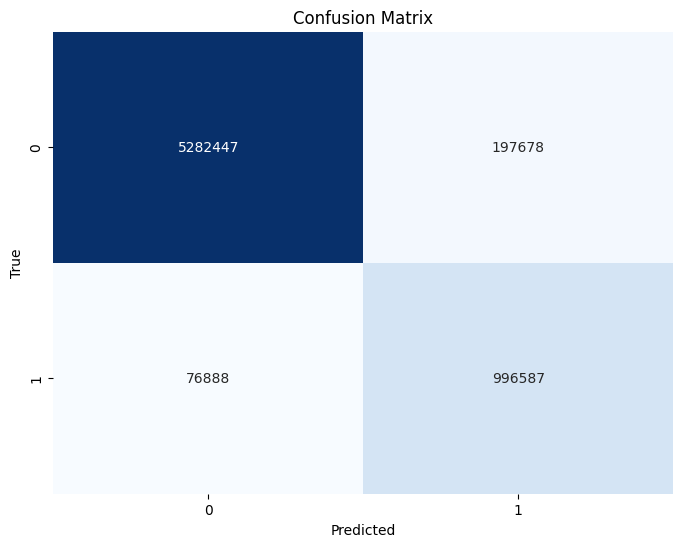

In [ ]:
model = UNet(
    spatial_dims=2,
    in_channels=3,   # Adjust according to your input channel
    out_channels=1,  # Binary segmentation
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)


model_load_path = "/content/drive/MyDrive/deplo_dataset/unet/Dice/unet.pth"  # Adjust to your model path
model.load_state_dict(torch.load(model_load_path))

# Usage example
avg_iou, accuracy, precision, recall, f1, cm = test_model(model, test_loader, device)

<ipython-input-20-546482141f5c>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path))
/usr/local/lib/python3.11/dist-packages/

Test Average IoU: 0.1521
Test Accuracy: 0.9581
Test Precision: 0.8345
Test Recall: 0.9284
Test F1 Score: 0.8789
Confusion Matrix:
[[5282447  197678]
 [  76888  996587]]


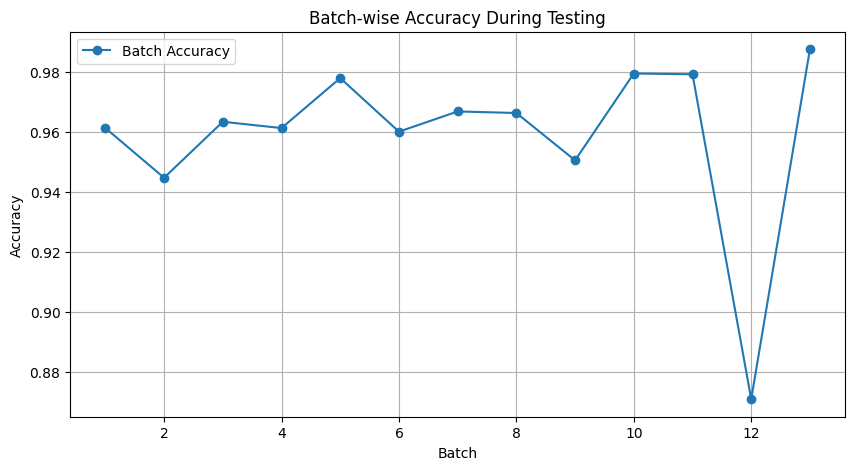

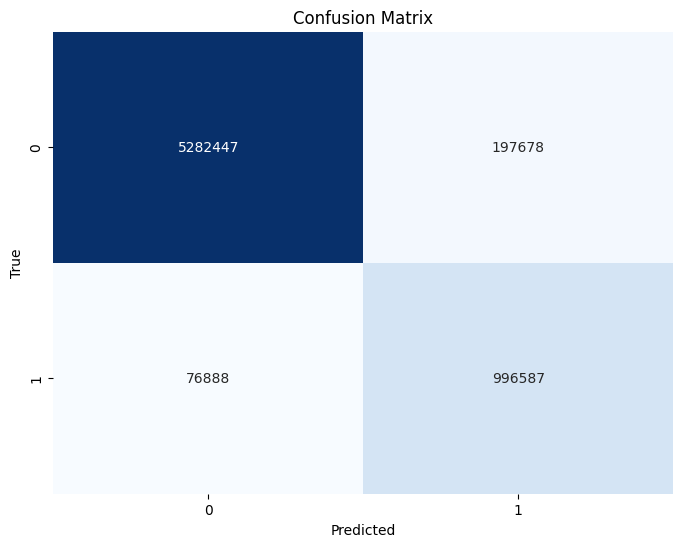

In [ ]:
model = UNet(
    spatial_dims=2,
    in_channels=3,   # Adjust according to your input channel
    out_channels=1,  # Binary segmentation
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)


model_load_path = "/content/drive/MyDrive/deplo_dataset/unet/Dice/unet.pth"  # Adjust to your model path
model.load_state_dict(torch.load(model_load_path))

# Usage example
avg_iou, accuracy, precision, recall, f1, cm = test_model2(model, test_loader, device)

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, data_loader, device, num_samples=5):

    model.eval()  # Set the model to evaluation mode
    samples_shown = 0  # Counter for the number of samples visualized

    with torch.no_grad():
        for batch_data in data_loader:
            images = batch_data["image"].to(device)
            masks = batch_data["mask"].to(device)

            # Get predictions from the model
            outputs = model(images)["out"]  # Extract the actual output tensor
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to convert to probabilities

            # Loop through each sample in the batch
            for i in range(images.shape[0]):
                if samples_shown >= num_samples:
                    return  # Stop once the required number of samples is shown

                # Get the data for the current sample
                image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
                mask = masks[i].cpu().numpy()[0]  # Ground truth mask
                prediction = outputs[i].cpu().numpy()[0]  # Model prediction

                # Plot the original image, ground truth mask, and prediction
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap="gray" if image.shape[2] == 1 else None)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap="gray")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(prediction, cmap="gray")
                plt.title("Model Prediction")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                samples_shown += 1


In [ ]:
visualize_predictions(model, val_loader, device, num_samples=5)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TypeError: new(): invalid data type 'str'

##**SegResNet**

Epoch 1/200


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.7190117520093918
Epoch 2/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.696772603392601


Validation Mean Dice Score: 0.0
Validation loss: 0.695399100963886
Validation Mean Dice Score (IoU): 0.0
Epoch 3/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.6883643406629563
Epoch 4/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.6804670286178589
Validation Mean Dice Score: 0.0
Validation loss: 0.6726620151446416
Validation Mean Dice Score (IoU): 0.0
Epoch 5/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


Training loss: 0.6706975305080414
Epoch 6/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.6649310058355331


Validation Mean Dice Score: 0.0
Validation loss: 0.6506745012906882
Validation Mean Dice Score (IoU): 0.0
Epoch 7/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.6578614062070847
Epoch 8/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.6503005659580231


Validation Mean Dice Score: 0.0
Validation loss: 0.6436087901775653
Validation Mean Dice Score (IoU): 0.0
Epoch 9/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.6419044706225395
Epoch 10/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Training loss: 0.636972268819809


Validation Mean Dice Score: 0.0
Validation loss: 0.6248549589743981
Validation Mean Dice Score (IoU): 0.0
Epoch 11/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.627841023504734
Epoch 12/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.6194070255756379


Validation Mean Dice Score: 0.0
Validation loss: 0.6060012991611774
Validation Mean Dice Score (IoU): 0.0
Epoch 13/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.6148097240924835
Epoch 14/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.6022895440459252


Validation Mean Dice Score: 0.0
Validation loss: 0.5871239717190082
Validation Mean Dice Score (IoU): 0.0
Epoch 15/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.5942140442132949
Epoch 16/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.5850633677840232


Validation Mean Dice Score: 0.0
Validation loss: 0.5763563857628748
Validation Mean Dice Score (IoU): 0.0
Epoch 17/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.5742329069972039
Epoch 18/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.5646669283509255


Validation Mean Dice Score: 0.0
Validation loss: 0.5601874544070318
Validation Mean Dice Score (IoU): 0.0
Epoch 19/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.5584592396020889
Epoch 20/200


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]

Training loss: 0.5466922724246979


Validation Mean Dice Score: 0.0
Validation loss: 0.5305844316115746
Validation Mean Dice Score (IoU): 0.0
Epoch 21/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.53488615244627
Epoch 22/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.5273887467384338


Validation Mean Dice Score: 0.0
Validation loss: 0.5173485164458935
Validation Mean Dice Score (IoU): 0.0
Epoch 23/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.5166753217577934
Epoch 24/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.5081577724218369


Validation Mean Dice Score: 0.0
Validation loss: 0.49171677231788635
Validation Mean Dice Score (IoU): 0.0
Epoch 25/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.4952232328057289
Epoch 26/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.4874436327815056


Validation Mean Dice Score: 0.0
Validation loss: 0.46545497270730823
Validation Mean Dice Score (IoU): 0.0
Epoch 27/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.4800962409377098
Epoch 28/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.4669597828388214


Validation Mean Dice Score: 0.0
Validation loss: 0.4637885001989511
Validation Mean Dice Score (IoU): 0.0
Epoch 29/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.45768803000450137
Epoch 30/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.4506901055574417


Validation Mean Dice Score: 0.0
Validation loss: 0.43909186812547535
Validation Mean Dice Score (IoU): 0.0
Epoch 31/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.442034892141819
Epoch 32/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.43169578671455383


Validation Mean Dice Score: 0.0
Validation loss: 0.4149341881275177
Validation Mean Dice Score (IoU): 0.0
Epoch 33/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.4178199362754822
Epoch 34/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.41504837170243264


Validation Mean Dice Score: 0.0
Validation loss: 0.408232161631951
Validation Mean Dice Score (IoU): 0.0
Epoch 35/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.4047586759924889
Epoch 36/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.39861628621816636


Validation Mean Dice Score: 0.0018137201953392762
Validation loss: 0.38889964727255016
Validation Mean Dice Score (IoU): 0.0018137201953392762
Epoch 37/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.38821430385112765
Epoch 38/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.38015437573194505


Validation Mean Dice Score: 0.0038964801441090037
Validation loss: 0.3796117305755615
Validation Mean Dice Score (IoU): 0.0038964801441090037
Epoch 39/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.3743673914670944
Epoch 40/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.3685740165412426


Validation Mean Dice Score: 0.0195671094294924
Validation loss: 0.3670639968835391
Validation Mean Dice Score (IoU): 0.0195671094294924
Epoch 41/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.34712152898311616
Epoch 42/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.3470825058221817


Validation Mean Dice Score: 0.005242165428801225
Validation loss: 0.3405719559926253
Validation Mean Dice Score (IoU): 0.005242165428801225
Epoch 43/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.34333651095628737
Epoch 44/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.3343328915536404


Validation Mean Dice Score: 0.018270069303420875
Validation loss: 0.32532116312247056
Validation Mean Dice Score (IoU): 0.018270069303420875
Epoch 45/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.33853725165128706
Epoch 46/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.3238280229270458


Validation Mean Dice Score: 0.0466433959081769
Validation loss: 0.3133944204220405
Validation Mean Dice Score (IoU): 0.0466433959081769
Epoch 47/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.3174366611242294
Epoch 48/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.3113343599438667


Validation Mean Dice Score: 0.04945123668473501
Validation loss: 0.3002385187607545
Validation Mean Dice Score (IoU): 0.04945123668473501
Epoch 49/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Training loss: 0.30896403297781944
Epoch 50/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.2944516944885254


Validation Mean Dice Score: 0.059849162944234334
Validation loss: 0.29088977437752944
Validation Mean Dice Score (IoU): 0.059849162944234334
Epoch 51/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.2920477700233459
Epoch 52/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.2917854078114033


Validation Mean Dice Score: 0.08801068999589635
Validation loss: 0.2702383055136754
Validation Mean Dice Score (IoU): 0.08801068999589635
Epoch 53/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.2890610860288143
Epoch 54/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.28225947871804236


Validation Mean Dice Score: 0.08840152005163524
Validation loss: 0.2788548102745643
Validation Mean Dice Score (IoU): 0.08840152005163524
Epoch 55/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.28039926528930664
Epoch 56/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.27199205502867696


Validation Mean Dice Score: 0.10787028231872962
Validation loss: 0.2467891161258404
Validation Mean Dice Score (IoU): 0.10787028231872962
Epoch 57/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.2682041746377945
Epoch 58/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.2604825885593891


Validation Mean Dice Score: 0.11744557693600655
Validation loss: 0.25343509018421173
Validation Mean Dice Score (IoU): 0.11744557693600655
Epoch 59/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.2597085776925087
Epoch 60/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.25425267830491066


Validation Mean Dice Score: 0.117930567487537
Validation loss: 0.24100039784724897
Validation Mean Dice Score (IoU): 0.117930567487537
Epoch 61/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.2492180158942938
Epoch 62/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.25347695976495743


Validation Mean Dice Score: 0.13758186279581144
Validation loss: 0.23786784593875593
Validation Mean Dice Score (IoU): 0.13758186279581144
Epoch 63/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.24214501559734344
Epoch 64/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.23609630979597568


Validation Mean Dice Score: 0.12153819009948236
Validation loss: 0.2299327626824379
Validation Mean Dice Score (IoU): 0.12153819009948236
Epoch 65/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.24849729523062705
Epoch 66/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.23328577488660812


Validation Mean Dice Score: 0.13655598719532674
Validation loss: 0.22949277323025924
Validation Mean Dice Score (IoU): 0.13655598719532674
Epoch 67/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.23540897578001022
Epoch 68/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.23544952884316445


Validation Mean Dice Score: 0.15462550005087486
Validation loss: 0.20541805315476197
Validation Mean Dice Score (IoU): 0.15462550005087486
Epoch 69/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.22918206982314587
Epoch 70/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.22303850412368775


Validation Mean Dice Score: 0.15108719625725195
Validation loss: 0.22840949262563998
Validation Mean Dice Score (IoU): 0.15108719625725195
Epoch 71/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.2411631841957569
Epoch 72/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.22120179384946823


Validation Mean Dice Score: 0.15415150958758134
Validation loss: 0.2387576286609356
Validation Mean Dice Score (IoU): 0.15415150958758134
Epoch 73/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.22403569340705873
Epoch 74/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.2167078622430563


Validation Mean Dice Score: 0.1727035165979312
Validation loss: 0.21554482613618559
Validation Mean Dice Score (IoU): 0.1727035165979312
Epoch 75/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.2173693663626909
Epoch 76/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.21692322686314583


Validation Mean Dice Score: 0.1676004474552778
Validation loss: 0.23033392200103173
Validation Mean Dice Score (IoU): 0.1676004474552778
Epoch 77/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.21407405905425547
Epoch 78/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.2142255025357008


Validation Mean Dice Score: 0.1767267053678202
Validation loss: 0.20172355152093446
Validation Mean Dice Score (IoU): 0.1767267053678202
Epoch 79/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training loss: 0.20584812834858895
Epoch 80/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.20847793966531752


Validation Mean Dice Score: 0.21306943664183983
Validation loss: 0.2062806269297233
Validation Mean Dice Score (IoU): 0.21306943664183983
Epoch 81/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.20704025886952876
Epoch 82/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.20588438495993613


Validation Mean Dice Score: 0.21270630050164002
Validation loss: 0.20540417616183942
Validation Mean Dice Score (IoU): 0.21270630050164002
Epoch 83/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.20950731344521045
Epoch 84/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.20099426604807377


Validation Mean Dice Score: 0.19092859737933254
Validation loss: 0.2091285758293592
Validation Mean Dice Score (IoU): 0.19092859737933254
Epoch 85/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.20470880836248398
Epoch 86/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.20378220908343792


Validation Mean Dice Score: 0.1999170923462281
Validation loss: 0.19114051415370062
Validation Mean Dice Score (IoU): 0.1999170923462281
Epoch 87/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.212484709918499
Epoch 88/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.20351807735860347


Validation Mean Dice Score: 0.2143023151617784
Validation loss: 0.1896958087499325
Validation Mean Dice Score (IoU): 0.2143023151617784
Epoch 89/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.19182274863123894
Epoch 90/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.20562482312321662


Validation Mean Dice Score: 0.2079244670099937
Validation loss: 0.18552734702825546
Validation Mean Dice Score (IoU): 0.2079244670099937
Epoch 91/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.19716125972568987
Epoch 92/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.1969513598829508
Validation Mean Dice Score: 0.25880769812143767
Validation loss: 0.20342409266875341
Validation Mean Dice Score (IoU): 0.25880769812143767
Epoch 93/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.2007754773646593
Epoch 94/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.189583887308836


Validation Mean Dice Score: 0.21690377650352624
Validation loss: 0.18889959500386164
Validation Mean Dice Score (IoU): 0.21690377650352624
Epoch 95/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.19575645543634893
Epoch 96/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.18954603716731072


Validation Mean Dice Score: 0.23203650346169105
Validation loss: 0.16962102571359047
Validation Mean Dice Score (IoU): 0.23203650346169105
Epoch 97/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.19372095711529255
Epoch 98/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.19171922281384468


Validation Mean Dice Score: 0.23346307974022168
Validation loss: 0.1849097449045915
Validation Mean Dice Score (IoU): 0.23346307974022168
Epoch 99/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.18904577910900117
Epoch 100/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.19343250893056393


Validation Mean Dice Score: 0.246442606815925
Validation loss: 0.1829580137362847
Validation Mean Dice Score (IoU): 0.246442606815925
Epoch 101/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.1863816214352846
Epoch 102/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.17998059079051018


Validation Mean Dice Score: 0.25937457540287423
Validation loss: 0.1783273030932133
Validation Mean Dice Score (IoU): 0.25937457540287423
Epoch 103/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.1875178811699152
Epoch 104/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1834260679781437


Validation Mean Dice Score: 0.22746089272774184
Validation loss: 0.20023970420543963
Validation Mean Dice Score (IoU): 0.22746089272774184
Epoch 105/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.20323414772748946
Epoch 106/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.19169260501861574


Validation Mean Dice Score: 0.2562598047348169
Validation loss: 0.18757784080046874
Validation Mean Dice Score (IoU): 0.2562598047348169
Epoch 107/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.17869222283363342
Epoch 108/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.20178745232522488


Validation Mean Dice Score: 0.2817005320237233
Validation loss: 0.19304813960423836
Validation Mean Dice Score (IoU): 0.2817005320237233
Epoch 109/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.1808622096478939
Epoch 110/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.18708919398486615


Validation Mean Dice Score: 0.2957054663162965
Validation loss: 0.18195018401512733
Validation Mean Dice Score (IoU): 0.2957054663162965
Epoch 111/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.18128459058701993
Epoch 112/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1885282089561224


Validation Mean Dice Score: 0.2787915167327111
Validation loss: 0.17754597675341827
Validation Mean Dice Score (IoU): 0.2787915167327111
Epoch 113/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.18095259204506875
Epoch 114/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.18480723969638346


Validation Mean Dice Score: 0.29247820721222806
Validation loss: 0.17599202577884382
Validation Mean Dice Score (IoU): 0.29247820721222806
Epoch 115/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.17829753175377847
Epoch 116/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.17880676984786986


Validation Mean Dice Score: 0.2974428339646413
Validation loss: 0.19321496670062727
Validation Mean Dice Score (IoU): 0.2974428339646413
Epoch 117/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.18917580910027026
Epoch 118/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.18663007497787476


Validation Mean Dice Score: 0.2805471967619199
Validation loss: 0.183274551652945
Validation Mean Dice Score (IoU): 0.2805471967619199
Epoch 119/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.17446306735277176
Epoch 120/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.1807631965726614


Validation Mean Dice Score: 0.3151848940895154
Validation loss: 0.17319780301589233
Validation Mean Dice Score (IoU): 0.3151848940895154
Epoch 121/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.17847401775419713
Epoch 122/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.17918249279260634


Validation Mean Dice Score: 0.3013029465308556
Validation loss: 0.18289318910011879
Validation Mean Dice Score (IoU): 0.3013029465308556
Epoch 123/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.17248419590294362
Epoch 124/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Training loss: 0.1743755269050598


Validation Mean Dice Score: 0.3056769371032715
Validation loss: 0.17304317997052118
Validation Mean Dice Score (IoU): 0.3056769371032715
Epoch 125/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Training loss: 0.17598048314452172
Epoch 126/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.17664685666561128


Validation Mean Dice Score: 0.3109217853500293
Validation loss: 0.17758724093437195
Validation Mean Dice Score (IoU): 0.3109217853500293
Epoch 127/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.17507434017956258
Epoch 128/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.17934874802827835


Validation Mean Dice Score: 0.3003841866380893
Validation loss: 0.1703641087963031
Validation Mean Dice Score (IoU): 0.3003841866380893
Epoch 129/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.17188247792422773
Epoch 130/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1734816864877939


Validation Mean Dice Score: 0.29839980888825196
Validation loss: 0.1646865394252997
Validation Mean Dice Score (IoU): 0.29839980888825196
Epoch 131/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.17626969128847123
Epoch 132/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.17128369770944118


Validation Mean Dice Score: 0.3463277312425467
Validation loss: 0.16046583022062594
Validation Mean Dice Score (IoU): 0.3463277312425467
Epoch 133/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.17093631096184253
Epoch 134/200


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]

Training loss: 0.17394416108727456


Validation Mean Dice Score: 0.32903932608090913
Validation loss: 0.16614135584005943
Validation Mean Dice Score (IoU): 0.32903932608090913
Epoch 135/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.17539125859737395
Epoch 136/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.1685764503479004


Validation Mean Dice Score: 0.35201775569182175
Validation loss: 0.1810050503565715
Validation Mean Dice Score (IoU): 0.35201775569182175
Epoch 137/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.1718677017092705
Epoch 138/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.1652286683768034


Validation Mean Dice Score: 0.3298115638586191
Validation loss: 0.17561747076419684
Validation Mean Dice Score (IoU): 0.3298115638586191
Epoch 139/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.16992865681648253
Epoch 140/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.17468551076948644


Validation Mean Dice Score: 0.30710664850014907
Validation loss: 0.16505092210494554
Validation Mean Dice Score (IoU): 0.30710664850014907
Epoch 141/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.16729996740818023
Epoch 142/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.16623248383402825


Validation Mean Dice Score: 0.30306421773723113
Validation loss: 0.1705559566617012
Validation Mean Dice Score (IoU): 0.30306421773723113
Epoch 143/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.16361225068569182
Epoch 144/200


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

Training loss: 0.1632436929643154


Validation Mean Dice Score: 0.331872175519283
Validation loss: 0.1626831189944194
Validation Mean Dice Score (IoU): 0.331872175519283
Epoch 145/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.16710216641426087
Epoch 146/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.16933876253664493


Validation Mean Dice Score: 0.36098203636132753
Validation loss: 0.16295049626093644
Validation Mean Dice Score (IoU): 0.36098203636132753
Epoch 147/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.17246552504599094
Epoch 148/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.1717107206583023


Validation Mean Dice Score: 0.30914895236492157
Validation loss: 0.1772959650709079
Validation Mean Dice Score (IoU): 0.30914895236492157
Epoch 149/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.1683147731423378
Epoch 150/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.16529114864766598


Validation Mean Dice Score: 0.3455967501952098
Validation loss: 0.1745446278498723
Validation Mean Dice Score (IoU): 0.3455967501952098
Epoch 151/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.16897741563618182
Epoch 152/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.16427009224891662


Validation Mean Dice Score: 0.305068973165292
Validation loss: 0.18074447890886894
Validation Mean Dice Score (IoU): 0.305068973165292
Epoch 153/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.1766086709499359
Epoch 154/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1696639133989811


Validation Mean Dice Score: 0.35793425142765045
Validation loss: 0.1631930063550289
Validation Mean Dice Score (IoU): 0.35793425142765045
Epoch 155/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.16032709501683712
Epoch 156/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.17785874642431737


Validation Mean Dice Score: 0.3641741688434894
Validation loss: 0.17544588790490076
Validation Mean Dice Score (IoU): 0.3641741688434894
Epoch 157/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.16426168136298658
Epoch 158/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.16428419709205627


Validation Mean Dice Score: 0.347781261572471
Validation loss: 0.17250263347075537
Validation Mean Dice Score (IoU): 0.347781261572471
Epoch 159/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.166117952093482
Epoch 160/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.16396881587803364


Validation Mean Dice Score: 0.3618103563785553
Validation loss: 0.1683252791945751
Validation Mean Dice Score (IoU): 0.3618103563785553
Epoch 161/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.15885536834597588
Epoch 162/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.16131351053714751


Validation Mean Dice Score: 0.36005983558984905
Validation loss: 0.18204775567238146
Validation Mean Dice Score (IoU): 0.36005983558984905
Epoch 163/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.1692905005812645
Epoch 164/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.16780408576130867


Validation Mean Dice Score: 0.34861166316729325
Validation loss: 0.17928036187703794
Validation Mean Dice Score (IoU): 0.34861166316729325
Epoch 165/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1583414862304926
Epoch 166/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.16504016809165478


Validation Mean Dice Score: 0.38250654248090893
Validation loss: 0.16271261698924577
Validation Mean Dice Score (IoU): 0.38250654248090893
Epoch 167/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.1611692325025797
Epoch 168/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.1602492332458496


Validation Mean Dice Score: 0.3992926719096991
Validation loss: 0.15802338604743665
Validation Mean Dice Score (IoU): 0.3992926719096991
Epoch 169/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.16503556840121747
Epoch 170/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.16572739116847515


Validation Mean Dice Score: 0.3710206196858333
Validation loss: 0.1826056860960447
Validation Mean Dice Score (IoU): 0.3710206196858333
Epoch 171/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.16505802549421789
Epoch 172/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.16464337930083275


Validation Mean Dice Score: 0.3848196852665681
Validation loss: 0.17040147001926714
Validation Mean Dice Score (IoU): 0.3848196852665681
Epoch 173/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Training loss: 0.1558902782201767
Epoch 174/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.1591813427209854


Validation Mean Dice Score: 0.38447260627379787
Validation loss: 0.17656798144945732
Validation Mean Dice Score (IoU): 0.38447260627379787
Epoch 175/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.15796008974313736
Epoch 176/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.15920726530253887


Validation Mean Dice Score: 0.4016498318658425
Validation loss: 0.17368740874987382
Validation Mean Dice Score (IoU): 0.4016498318658425
Epoch 177/200


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Training loss: 0.15940059281885624
Epoch 178/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.1542908889055252


Validation Mean Dice Score: 0.3930389273625154
Validation loss: 0.16316729726699683
Validation Mean Dice Score (IoU): 0.3930389273625154
Epoch 179/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.15662764556705952
Epoch 180/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.16162316612899302


Validation Mean Dice Score: 0.3781043107693012
Validation loss: 0.162302767428068
Validation Mean Dice Score (IoU): 0.3781043107693012
Epoch 181/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.1610799377411604
Epoch 182/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.16315796807408334


Validation Mean Dice Score: 0.38532155522933376
Validation loss: 0.17254461921178377
Validation Mean Dice Score (IoU): 0.38532155522933376
Epoch 183/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.16034203179180623
Epoch 184/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.15763286121189593


Validation Mean Dice Score: 0.3873815421874707
Validation loss: 0.174832702256166
Validation Mean Dice Score (IoU): 0.3873815421874707
Epoch 185/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.15778579249978064
Epoch 186/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.15906710430979729


Validation Mean Dice Score: 0.3740919361320826
Validation loss: 0.15664880206951728
Validation Mean Dice Score (IoU): 0.3740919361320826
Epoch 187/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1598047536611557
Epoch 188/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

Training loss: 0.15551418147981166


Validation Mean Dice Score: 0.4244174435734749
Validation loss: 0.1736348236982639
Validation Mean Dice Score (IoU): 0.4244174435734749
Epoch 189/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.16085813224315643
Epoch 190/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.16045698307454587


Validation Mean Dice Score: 0.40448565551867854
Validation loss: 0.1703145423760781
Validation Mean Dice Score (IoU): 0.40448565551867854
Epoch 191/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.16000947497785092
Epoch 192/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

Training loss: 0.1597312267869711


Validation Mean Dice Score: 0.37857196078850675
Validation loss: 0.19175239652395248
Validation Mean Dice Score (IoU): 0.37857196078850675
Epoch 193/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1653818192332983
Epoch 194/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

Training loss: 0.14785905204713345


Validation Mean Dice Score: 0.4002620531962468
Validation loss: 0.17152718683848014
Validation Mean Dice Score (IoU): 0.4002620531962468
Epoch 195/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.15268153436481952
Epoch 196/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.15306476406753064


Validation Mean Dice Score: 0.4192664944208585
Validation loss: 0.16112709905092532
Validation Mean Dice Score (IoU): 0.4192664944208585
Epoch 197/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.15496958121657373
Epoch 198/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.14809502847492695


Validation Mean Dice Score: 0.4147173727934177
Validation loss: 0.15500925252070794
Validation Mean Dice Score (IoU): 0.4147173727934177
Epoch 199/200


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Training loss: 0.15529647313058376
Epoch 200/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]

Training loss: 0.15523139409720899


Validation Mean Dice Score: 0.40534739884046406
Validation loss: 0.15428572663894066
Validation Mean Dice Score (IoU): 0.40534739884046406
Model saved to /content/drive/MyDrive/deplo_dataset/segresnet/segresnet.pth


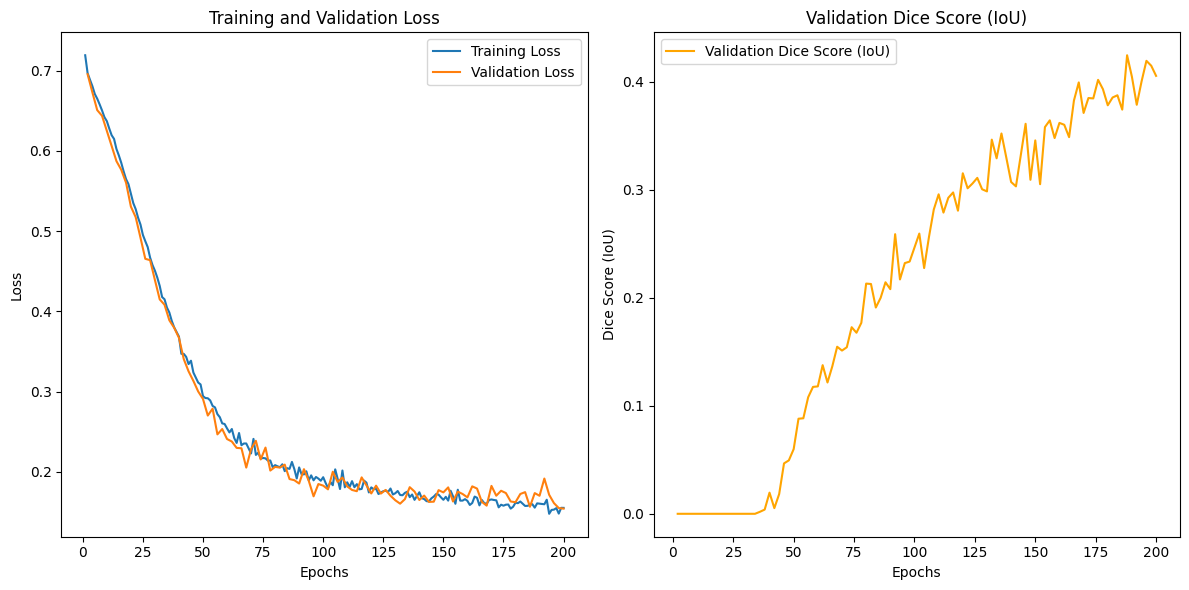

Training complete!


In [ ]:
# Define the SegResNet model
model = SegResNet(
    spatial_dims=2,          # Set to 2 for 2D images, or 3 for 3D images
    in_channels=3,           # Number of input channels (e.g., 3 for RGB images, 1 for grayscale)
    out_channels=1,          # Number of output channels (1 for binary segmentation)
    dropout_prob=0.2         # Dropout probability for regularization
).to(device)  # Move model to the appropriate device (GPU or CPU)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function=DiceLoss(sigmoid=True)
dice_metric=DiceMetric(include_background=False, reduction='mean')

model_save_dir = "/content/drive/MyDrive/deplo_dataset/segresnet"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_path = os.path.join(model_save_dir, "segresnet.pth")
training(model, model_save_dir, model_save_path)

Test Average IoU: 0.1378
Test Accuracy: 0.9541
Test Precision: 0.8734
Test Recall: 0.8415
Test F1 Score: 0.8571
Confusion Matrix:
[[5349163  130962]
 [ 170143  903332]]


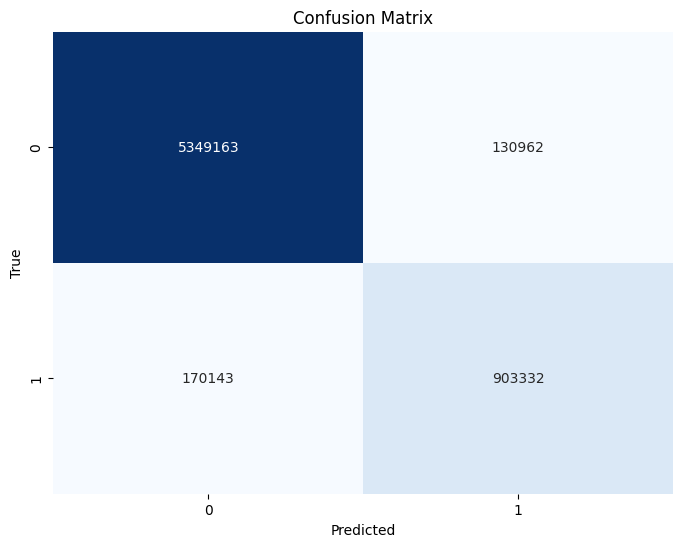

In [ ]:
model = SegResNet(
    spatial_dims=2,          # Set to 2 for 2D images, or 3 for 3D images
    in_channels=3,           # Number of input channels (e.g., 3 for RGB images, 1 for grayscale)
    out_channels=1,          # Number of output channels (1 for binary segmentation)
    dropout_prob=0.2         # Dropout probability for regularization
).to(device)  # Move model to the appropriate device (GPU or CPU)

model_load_path = "/content/drive/MyDrive/deplo_dataset/segresnet/segresnet.pth"
model.load_state_dict(torch.load(model_load_path))

# Usage example
avg_iou, accuracy, precision, recall, f1, cm = test_model(model, test_loader, device)

##**PSPNet**

Epoch 1/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.540416206419468
Epoch 2/200


100%|██████████| 100/100 [00:49<00:00,  2.00it/s]

Training loss: 0.3501764762401581


Validation Loss: 0.3019
Validation Dice Score: 0.0771
Epoch 3/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.2938666173815727
Epoch 4/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.2687017984688282


Validation Loss: 0.2343
Validation Dice Score: 0.1966
Epoch 5/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.24810716450214387
Epoch 6/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.23646160200238228


Validation Loss: 0.2365
Validation Dice Score: 0.3053
Epoch 7/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.23064153723418712
Epoch 8/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.21761323250830172


Validation Loss: 0.2323
Validation Dice Score: 0.2708
Epoch 9/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.20893310509622098
Epoch 10/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.20301477305591106


Validation Loss: 0.2089
Validation Dice Score: 0.4157
Epoch 11/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.19683458782732488
Epoch 12/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.1948796644806862


Validation Loss: 0.1936
Validation Dice Score: 0.4784
Epoch 13/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.19136849626898766
Epoch 14/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.1913133117556572


Validation Loss: 0.1838
Validation Dice Score: 0.5140
Epoch 15/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Training loss: 0.1841972192376852
Epoch 16/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.18066831044852733


Validation Loss: 0.1859
Validation Dice Score: 0.5024
Epoch 17/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.18294378913939
Epoch 18/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]

Training loss: 0.17770025692880154


Validation Loss: 0.1831
Validation Dice Score: 0.5356
Epoch 19/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.17164634458720684
Epoch 20/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.16711279898881912
Validation Loss: 0.1725
Validation Dice Score: 0.5626
Epoch 21/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.16271182179450988
Epoch 22/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.16459270410239696


Validation Loss: 0.1759
Validation Dice Score: 0.5663
Epoch 23/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.16752653189003466
Epoch 24/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.15803241051733494


Validation Loss: 0.1811
Validation Dice Score: 0.5810
Epoch 25/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.15688470028340817
Epoch 26/200


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]

Training loss: 0.15834392733871938


Validation Loss: 0.1719
Validation Dice Score: 0.6589
Epoch 27/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.15425023145973682
Epoch 28/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.15795166417956352


Validation Loss: 0.1796
Validation Dice Score: 0.5434
Epoch 29/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.15142987050116063
Epoch 30/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.15372264690697193


Validation Loss: 0.1717
Validation Dice Score: 0.6834
Epoch 31/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


Training loss: 0.1520144373178482
Epoch 32/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.1471652240306139
Validation Loss: 0.1618
Validation Dice Score: 0.6667
Epoch 33/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training loss: 0.14752279318869113
Epoch 34/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.1458053246885538


Validation Loss: 0.1635
Validation Dice Score: 0.6927
Epoch 35/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.14190941534936427
Epoch 36/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.14354102961719037


Validation Loss: 0.1749
Validation Dice Score: 0.7415
Epoch 37/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.13647034741938113
Epoch 38/200


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Training loss: 0.14344430901110172


Validation Loss: 0.1629
Validation Dice Score: 0.6662
Epoch 39/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.13764871068298817
Epoch 40/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.13652440197765828


Validation Loss: 0.1570
Validation Dice Score: 0.7319
Epoch 41/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.13394430711865424
Epoch 42/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.13629209041595458


Validation Loss: 0.1647
Validation Dice Score: 0.6571
Epoch 43/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.13641197264194488
Epoch 44/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.137181940600276


Validation Loss: 0.1716
Validation Dice Score: 0.6577
Epoch 45/200


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


Training loss: 0.13299926169216633
Epoch 46/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.12995396591722966


Validation Loss: 0.1640
Validation Dice Score: 0.6315
Epoch 47/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.129371275305748
Epoch 48/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.12983377367258073


Validation Loss: 0.1712
Validation Dice Score: 0.7165
Epoch 49/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.1292392484843731
Epoch 50/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.12861508518457412


Validation Loss: 0.1584
Validation Dice Score: 0.6825
Epoch 51/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.12921678632497788
Epoch 52/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Training loss: 0.1263219889998436
Validation Loss: 0.1542
Validation Dice Score: 0.6923
Epoch 53/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training loss: 0.12789161317050457
Epoch 54/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.12260012209415436


Validation Loss: 0.1623
Validation Dice Score: 0.7513
Epoch 55/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.12118938557803631
Epoch 56/200


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]

Training loss: 0.1268148174881935


Validation Loss: 0.1590
Validation Dice Score: 0.7091
Epoch 57/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Training loss: 0.12316746301949025
Epoch 58/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.12745390243828297


Validation Loss: 0.1617
Validation Dice Score: 0.7338
Epoch 59/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Training loss: 0.1318259171396494
Epoch 60/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.12055959060788154


Validation Loss: 0.1492
Validation Dice Score: 0.7046
Epoch 61/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.1184212975949049
Epoch 62/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.12202919848263263


Validation Loss: 0.1593
Validation Dice Score: 0.7076
Epoch 63/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.12003001101315021
Epoch 64/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.12123117044568062


Validation Loss: 0.1593
Validation Dice Score: 0.7390
Epoch 65/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.12233293533325196
Epoch 66/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.11381343469023704


Validation Loss: 0.1647
Validation Dice Score: 0.7964
Epoch 67/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.12109186396002769
Epoch 68/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.11716578759253025


Validation Loss: 0.1581
Validation Dice Score: 0.7081
Epoch 69/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.11558106482028961
Epoch 70/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.11691934458911418


Validation Loss: 0.1585
Validation Dice Score: 0.7643
Epoch 71/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.11539536029100418
Epoch 72/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.11326872296631336


Validation Loss: 0.1588
Validation Dice Score: 0.7393
Epoch 73/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.11092261508107186
Epoch 74/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]

Training loss: 0.11091491624712944


Validation Loss: 0.1559
Validation Dice Score: 0.7680
Epoch 75/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.11015010431408882
Epoch 76/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.10832046329975129


Validation Loss: 0.1469
Validation Dice Score: 0.7437
Epoch 77/200


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Training loss: 0.10769839756190777
Epoch 78/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.1094379572570324


Validation Loss: 0.1504
Validation Dice Score: 0.7364
Epoch 79/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.11294033072888851
Epoch 80/200


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

Training loss: 0.11044160202145577


Validation Loss: 0.1640
Validation Dice Score: 0.6682
Epoch 81/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Training loss: 0.11280502602458001
Epoch 82/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.1113993463665247


Validation Loss: 0.1573
Validation Dice Score: 0.7678
Epoch 83/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.11257362455129623
Epoch 84/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.10922848284244538


Validation Loss: 0.1589
Validation Dice Score: 0.7423
Epoch 85/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.10951558157801627
Epoch 86/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.10925397582352162


Validation Loss: 0.1499
Validation Dice Score: 0.7471
Epoch 87/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.10819364473223686
Epoch 88/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.10748189009726047


Validation Loss: 0.1630
Validation Dice Score: 0.7091
Epoch 89/200


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Training loss: 0.10760820604860782
Epoch 90/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]

Training loss: 0.10466807991266251


Validation Loss: 0.1400
Validation Dice Score: 0.7575
Epoch 91/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Training loss: 0.10558964602649212
Epoch 92/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.10964477427303791


Validation Loss: 0.1437
Validation Dice Score: 0.7487
Epoch 93/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.10815488077700137
Epoch 94/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.10243421882390975


Validation Loss: 0.1495
Validation Dice Score: 0.7797
Epoch 95/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.10176468782126903
Epoch 96/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.1059126752614975


Validation Loss: 0.1555
Validation Dice Score: 0.7784
Epoch 97/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.10279391437768937
Epoch 98/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.10349408455193043


Validation Loss: 0.1528
Validation Dice Score: 0.7506
Epoch 99/200


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Training loss: 0.10132692836225032
Epoch 100/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]

Training loss: 0.10383522637188435


Validation Loss: 0.1506
Validation Dice Score: 0.8090
Epoch 101/200


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Training loss: 0.10442570514976979
Epoch 102/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Training loss: 0.10576172545552254


Validation Loss: 0.1563
Validation Dice Score: 0.8001
Epoch 103/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.10297351576387882
Epoch 104/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.10515487916767598


Validation Loss: 0.1635
Validation Dice Score: 0.7294
Epoch 105/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.10520351186394691
Epoch 106/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.10496550150215626


Validation Loss: 0.1440
Validation Dice Score: 0.7369
Epoch 107/200


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Training loss: 0.10338511399924755
Epoch 108/200


 19%|█▉        | 19/100 [00:13<00:44,  1.82it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7acd21730700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 20%|██        | 20/100 [00:15<01:27,  1.09s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7acd21730700>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7acd21730700>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Training loss: 0.10433326780796051


Validation Loss: 0.1606
Validation Dice Score: 0.7101
Epoch 109/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.10149158336222172
Epoch 110/200


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]

Training loss: 0.09575856238603592


Validation Loss: 0.1428
Validation Dice Score: 0.7671
Epoch 111/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.10121529787778855
Epoch 112/200


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]

Training loss: 0.10127855837345123


Validation Loss: 0.1644
Validation Dice Score: 0.7019
Epoch 113/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.10000682912766934
Epoch 114/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.10598469711840153


Validation Loss: 0.1493
Validation Dice Score: 0.7956
Epoch 115/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.09872616536915302
Epoch 116/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.09922624222934245


Validation Loss: 0.1441
Validation Dice Score: 0.7542
Epoch 117/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.09736349269747734
Epoch 118/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.09722293838858605


Validation Loss: 0.1394
Validation Dice Score: 0.7754
Epoch 119/200


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Training loss: 0.09603582769632339
Epoch 120/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.09409952536225319


Validation Loss: 0.1485
Validation Dice Score: 0.8104
Epoch 121/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.09807367615401745
Epoch 122/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.09266346752643585


Validation Loss: 0.1432
Validation Dice Score: 0.8212
Epoch 123/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Training loss: 0.09813291899859905
Epoch 124/200


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]

Training loss: 0.09734140053391456


Validation Loss: 0.1522
Validation Dice Score: 0.7971
Epoch 125/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.10118670158088207
Epoch 126/200


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]

Training loss: 0.09732077032327652


Validation Loss: 0.1430
Validation Dice Score: 0.7878
Epoch 127/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.09652573853731156
Epoch 128/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.09859007127583026


Validation Loss: 0.1388
Validation Dice Score: 0.7879
Epoch 129/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Training loss: 0.09325920522212983
Epoch 130/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.09192745566368103


Validation Loss: 0.1649
Validation Dice Score: 0.7579
Epoch 131/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training loss: 0.10470128394663333
Epoch 132/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.09543866612017154


Validation Loss: 0.1541
Validation Dice Score: 0.7465
Epoch 133/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


Training loss: 0.09532021909952164
Epoch 134/200


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Training loss: 0.0994560919702053


Validation Loss: 0.1456
Validation Dice Score: 0.8126
Epoch 135/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.09126013457775116
Epoch 136/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Training loss: 0.09502726510167121
Validation Loss: 0.1432
Validation Dice Score: 0.7870
Epoch 137/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.0935793948918581
Epoch 138/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.09672792851924897


Validation Loss: 0.1548
Validation Dice Score: 0.8099
Epoch 139/200


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Training loss: 0.0916378390043974
Epoch 140/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.09114287763834


Validation Loss: 0.1449
Validation Dice Score: 0.8075
Epoch 141/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


Training loss: 0.09208222180604934
Epoch 142/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]

Training loss: 0.09306044444441795


Validation Loss: 0.1560
Validation Dice Score: 0.8055
Epoch 143/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.09768150724470616
Epoch 144/200


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]

Training loss: 0.0919328984618187


Validation Loss: 0.1510
Validation Dice Score: 0.7472
Epoch 145/200


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Training loss: 0.09502258941531182
Epoch 146/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Training loss: 0.09191483847796916


Validation Loss: 0.1670
Validation Dice Score: 0.7343
Epoch 147/200


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


Training loss: 0.09505829788744449
Epoch 148/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Training loss: 0.0929330275207758


Validation Loss: 0.1430
Validation Dice Score: 0.8261
Epoch 149/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training loss: 0.09269948676228523
Epoch 150/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Training loss: 0.08976811170578003


Validation Loss: 0.1444
Validation Dice Score: 0.7872
Epoch 151/200


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Training loss: 0.09034614831209183
Epoch 152/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

Training loss: 0.08852772243320942


Validation Loss: 0.1581
Validation Dice Score: 0.7288
Epoch 153/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Training loss: 0.09135037891566754
Epoch 154/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

Training loss: 0.08868653386831284


Validation Loss: 0.1450
Validation Dice Score: 0.7940
Epoch 155/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.09476933598518372
Epoch 156/200


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]

Training loss: 0.09356423676013946


Validation Loss: 0.1688
Validation Dice Score: 0.7604
Epoch 157/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.0917927660793066
Epoch 158/200


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


Training loss: 0.0917086223512888
Validation Loss: 0.1451
Validation Dice Score: 0.7820
Epoch 159/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.08959714591503143
Epoch 160/200


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Training loss: 0.08637434802949429


Validation Loss: 0.1499
Validation Dice Score: 0.7614
Epoch 161/200


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Training loss: 0.0869294522702694
Epoch 162/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Training loss: 0.08512593008577823


Validation Loss: 0.1455
Validation Dice Score: 0.7936
Epoch 163/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.09126693271100521
Epoch 164/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Training loss: 0.08846490494906903


Validation Loss: 0.1536
Validation Dice Score: 0.7544
Epoch 165/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.09197444781661034
Epoch 166/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.08868924766778946


Validation Loss: 0.1551
Validation Dice Score: 0.7892
Epoch 167/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.08670503705739975
Epoch 168/200


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

Training loss: 0.08743908479809762


Validation Loss: 0.1388
Validation Dice Score: 0.8242
Epoch 169/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training loss: 0.08376098319888114
Epoch 170/200


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]

Training loss: 0.08686758399009704


Validation Loss: 0.1430
Validation Dice Score: 0.8007
Epoch 171/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.08829433403909207
Epoch 172/200


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

Training loss: 0.09117702774703502


Validation Loss: 0.1445
Validation Dice Score: 0.7962
Epoch 173/200


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Training loss: 0.08606890946626664
Epoch 174/200


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Training loss: 0.08807621486485004


Validation Loss: 0.1665
Validation Dice Score: 0.7480
Epoch 175/200


100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


Training loss: 0.09576929613947868
Epoch 176/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.09162066258490086


Validation Loss: 0.1438
Validation Dice Score: 0.8011
Epoch 177/200


100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


Training loss: 0.08808905959129333
Epoch 178/200


100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

Training loss: 0.0863945633918047


Validation Loss: 0.1483
Validation Dice Score: 0.7876
Epoch 179/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.08475236773490906
Epoch 180/200


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

Training loss: 0.08826960206031799


Validation Loss: 0.1424
Validation Dice Score: 0.7912
Epoch 181/200


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Training loss: 0.08817006714642048
Epoch 182/200


100%|██████████| 100/100 [00:44<00:00,  2.27it/s]

Training loss: 0.08622195899486541


Validation Loss: 0.1572
Validation Dice Score: 0.7629
Epoch 183/200


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


Training loss: 0.08557109266519547
Epoch 184/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]

Training loss: 0.08538429953157901


Validation Loss: 0.1493
Validation Dice Score: 0.7631
Epoch 185/200


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Training loss: 0.08370760850608348
Epoch 186/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Training loss: 0.08573786765336991


Validation Loss: 0.1330
Validation Dice Score: 0.7749
Epoch 187/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training loss: 0.08410431690514088
Epoch 188/200


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]

Training loss: 0.08482741743326187


Validation Loss: 0.1513
Validation Dice Score: 0.7944
Epoch 189/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


Training loss: 0.08624638721346856
Epoch 190/200


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

Training loss: 0.08605611205101013


Validation Loss: 0.1514
Validation Dice Score: 0.7851
Epoch 191/200


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Training loss: 0.08669933624565601
Epoch 192/200


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Training loss: 0.08911912702023983


Validation Loss: 0.1486
Validation Dice Score: 0.7805
Epoch 193/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training loss: 0.08647608190774918
Epoch 194/200


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]

Training loss: 0.08998302087187766


Validation Loss: 0.1490
Validation Dice Score: 0.7946
Epoch 195/200


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Training loss: 0.08414058409631252
Epoch 196/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.08841387160122395


Validation Loss: 0.1480
Validation Dice Score: 0.7519
Epoch 197/200


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


Training loss: 0.08513879299163818
Epoch 198/200


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

Training loss: 0.08265691041946412


Validation Loss: 0.1493
Validation Dice Score: 0.8058
Epoch 199/200


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Training loss: 0.08128143735229969
Epoch 200/200


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]

Training loss: 0.0809112212061882


Validation Loss: 0.1451
Validation Dice Score: 0.8001
Model saved to /content/drive/MyDrive/deplo_dataset/pspnet/pspnet.pth


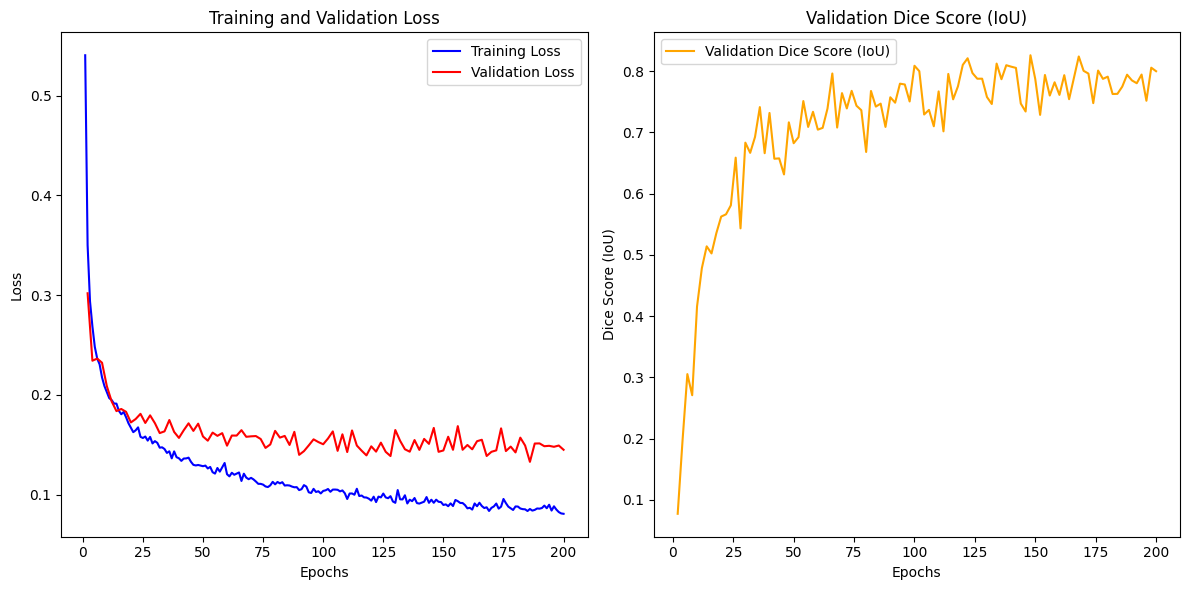

In [ ]:
# Initialize the model (PSPNet) and move it to the correct device
model = smp.PSPNet(
    encoder_name="resnet34",  # Encoder name
    encoder_weights="imagenet",  # Pre-trained weights
    in_channels=3,  # RGB images
    classes=1  # Binary segmentation
)

# Move the model to the device (GPU or CPU)
model = model.to(device)

model_save_dir = "/content/drive/MyDrive/deplo_dataset/pspnet"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_path = os.path.join(model_save_dir, "pspnet.pth")
new_training(model, model_save_dir, model_save_path)

#loss_function = torch.nn.BCEWithLogitsLoss()

<ipython-input-42-2690951da704>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Test Average IoU: 0.1450
Test Accuracy: 0.9682
Test Precision: 0.9174
Test Recall: 0.8853
Test F1 Score: 0.9010
Confusion Matrix:
[[5394575   85550]
 [ 123175  950300]]


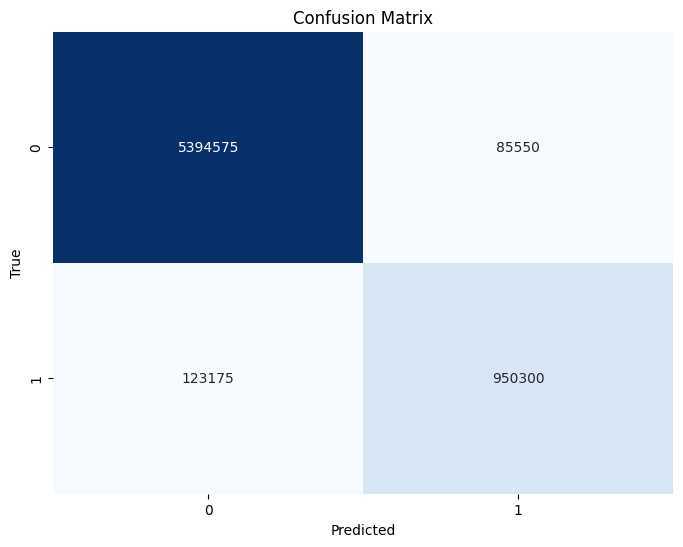

In [ ]:
model = smp.PSPNet(
    encoder_name="resnet34",  # Encoder name
    encoder_weights="imagenet",  # Pre-trained weights
    in_channels=3,  # RGB images
    classes=1  # Binary segmentation
).to(device)

model.load_state_dict(torch.load(model_save_path))

# Usage example
avg_iou, accuracy, precision, recall, f1, cm = test_model(model, test_loader, device)

##**DUCK-Net** *(Dense Upsampling Convolutional Kernel Network)*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, add, BatchNormalization, Activation, ReLU, UpSampling2D, Add, Concatenate #BatchNormalizationV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50

###ConvBlock2D.py

In [ ]:
kernel_initializer = 'he_uniform'

def conv_block_2D(x, filters, block_type, repeat=1, dilation_rate=1, size=3, padding='same'):
    result = x

    for i in range(0, repeat):

        if block_type == 'separated':
            result = separated_conv2D_block(result, filters, size=size, padding=padding)
        elif block_type == 'duckv2':
            result = duckv2_conv2D_block(result, filters, size=size)
        elif block_type == 'midscope':
            result = midscope_conv2D_block(result, filters)
        elif block_type == 'widescope':
            result = widescope_conv2D_block(result, filters)
        elif block_type == 'resnet':
            result = resnet_conv2D_block(result, filters, dilation_rate)
        elif block_type == 'conv':
            result = Conv2D(filters, (size, size),
                            activation='relu', kernel_initializer=kernel_initializer, padding=padding)(result)
        elif block_type == 'double_convolution':
            result = double_convolution_with_batch_normalization(result, filters, dilation_rate)

        else:
            return None

    return result


def duckv2_conv2D_block(x, filters, size):
    x = BatchNormalization(axis=-1)(x)
    x1 = widescope_conv2D_block(x, filters)

    x2 = midscope_conv2D_block(x, filters)

    x3 = conv_block_2D(x, filters, 'resnet', repeat=1)

    x4 = conv_block_2D(x, filters, 'resnet', repeat=2)

    x5 = conv_block_2D(x, filters, 'resnet', repeat=3)

    x6 = separated_conv2D_block(x, filters, size=6, padding='same')

    x = add([x1, x2, x3, x4, x5, x6])

    x = BatchNormalization(axis=-1)(x)

    return x


def separated_conv2D_block(x, filters, size=3, padding='same'):
    x = Conv2D(filters, (1, size), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (size, 1), activation='relu', kernel_initializer=kernel_initializer, padding=padding)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def midscope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def widescope_conv2D_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=1)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=2)(x)

    x = BatchNormalization(axis=-1)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=3)(x)

    x = BatchNormalization(axis=-1)(x)

    return x


def resnet_conv2D_block(x, filters, dilation_rate=1):
    x1 = Conv2D(filters, (1, 1), activation='relu', kernel_initializer=kernel_initializer, padding='same',
                dilation_rate=dilation_rate)(x)

    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x_final = add([x, x1])

    x_final = BatchNormalization(axis=-1)(x_final)

    return x_final


def double_convolution_with_batch_normalization(x, filters, dilation_rate=1):
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization(axis=-1)(x)

    return x

###ImageLoader2D.py  ΝΑ ΔΟΥΜΕ ΜΗΠΩΣ ΔΕΝ ΧΡΕΙΑΖΕΤΑΙ ΑΛΛΑ ΤΙ ΕΠΕΞΕΡΓΑΣΙΑ ΚΑΝΕΙ

In [ ]:
import glob

import numpy as np
from PIL import Image
from skimage.io import imread
from tqdm import tqdm

folder_path = ""  # Add the path to your data directory


def load_data(img_height, img_width, images_to_be_loaded, dataset):
    IMAGES_PATH = folder_path + 'images/'
    MASKS_PATH = folder_path + 'masks/'

    if dataset == 'kvasir':
        train_ids = glob.glob(IMAGES_PATH + "*.jpg")

    if dataset == 'cvc-clinicdb':
        train_ids = glob.glob(IMAGES_PATH + "*.tif")

    if dataset == 'cvc-colondb' or dataset == 'etis-laribpolypdb':
        train_ids = glob.glob(IMAGES_PATH + "*.png")

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    X_train = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y_train = np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        X_train[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        for i in range(img_height):
            for j in range(img_width):
                if mask_[i, j] >= 127:
                    mask[i, j] = 1

        Y_train[n] = mask

    Y_train = np.expand_dims(Y_train, axis=-1)

    return X_train, Y_train

###Model Architecture

In [ ]:
kernel_initializer = 'he_uniform'
interpolation = "nearest"


def create_model(img_height, img_width, input_chanels, out_classes, starting_filters):
    input_layer = tf.keras.layers.Input((img_height, img_width, input_chanels))

    print('Starting DUCK-Net')

    p1 = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(input_layer)
    p2 = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(p1)
    p3 = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(p2)
    p4 = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(p3)
    p5 = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(p4)

    t0 = conv_block_2D(input_layer, starting_filters, 'duckv2', repeat=1)

    l1i = Conv2D(starting_filters * 2, 2, strides=2, padding='same')(t0)
    s1 = add([l1i, p1])
    t1 = conv_block_2D(s1, starting_filters * 2, 'duckv2', repeat=1)

    l2i = Conv2D(starting_filters * 4, 2, strides=2, padding='same')(t1)
    s2 = add([l2i, p2])
    t2 = conv_block_2D(s2, starting_filters * 4, 'duckv2', repeat=1)

    l3i = Conv2D(starting_filters * 8, 2, strides=2, padding='same')(t2)
    s3 = add([l3i, p3])
    t3 = conv_block_2D(s3, starting_filters * 8, 'duckv2', repeat=1)

    l4i = Conv2D(starting_filters * 16, 2, strides=2, padding='same')(t3)
    s4 = add([l4i, p4])
    t4 = conv_block_2D(s4, starting_filters * 16, 'duckv2', repeat=1)

    l5i = Conv2D(starting_filters * 32, 2, strides=2, padding='same')(t4)
    s5 = add([l5i, p5])
    t51 = conv_block_2D(s5, starting_filters * 32, 'resnet', repeat=2)
    t53 = conv_block_2D(t51, starting_filters * 16, 'resnet', repeat=2)

    l5o = UpSampling2D((2, 2), interpolation=interpolation)(t53)
    c4 = add([l5o, t4])
    q4 = conv_block_2D(c4, starting_filters * 8, 'duckv2', repeat=1)

    l4o = UpSampling2D((2, 2), interpolation=interpolation)(q4)
    c3 = add([l4o, t3])
    q3 = conv_block_2D(c3, starting_filters * 4, 'duckv2', repeat=1)

    l3o = UpSampling2D((2, 2), interpolation=interpolation)(q3)
    c2 = add([l3o, t2])
    q6 = conv_block_2D(c2, starting_filters * 2, 'duckv2', repeat=1)

    l2o = UpSampling2D((2, 2), interpolation=interpolation)(q6)
    c1 = add([l2o, t1])
    q1 = conv_block_2D(c1, starting_filters, 'duckv2', repeat=1)

    l1o = UpSampling2D((2, 2), interpolation=interpolation)(q1)
    c0 = add([l1o, t0])
    z1 = conv_block_2D(c0, starting_filters, 'duckv2', repeat=1)

    output = Conv2D(out_classes, (1, 1), activation='sigmoid')(z1)

    model = Model(inputs=input_layer, outputs=output)

    return model

In [ ]:
import tensorflow as tf

# Define augmentation functions using tf.image

def random_rotate(image, mask, max_angle=30):
    angle = tf.random.uniform([], -max_angle, max_angle, dtype=tf.float32)
    image = tf.image.rot90(image, k=angle // 90)
    mask = tf.image.rot90(mask, k=angle // 90)
    return image, mask

def random_flip(image, mask):
    # Randomly flip horizontally and vertically
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    mask = tf.image.random_flip_left_right(mask)
    mask = tf.image.random_flip_up_down(mask)
    return image, mask

def random_zoom(image, mask, min_zoom=0.8, max_zoom=1.2):
    scale = tf.random.uniform([], min_zoom, max_zoom)
    image = tf.image.resize(image, [tf.cast(tf.shape(image)[0] * scale, tf.int32), tf.cast(tf.shape(image)[1] * scale, tf.int32)])
    mask = tf.image.resize(mask, [tf.cast(tf.shape(mask)[0] * scale, tf.int32), tf.cast(tf.shape(mask)[1] * scale, tf.int32)])
    return image, mask

# Apply augmentations to dataset
def apply_augmentations(image, mask):
    image, mask = random_rotate(image, mask)
    image, mask = random_flip(image, mask)
    image, mask = random_zoom(image, mask)
    return image, mask

# Create dataset using tf.data and apply augmentations
def create_dataset(images, masks, batch_size=8):
    def load_image(image_path, mask_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_jpeg(mask, channels=1)
        mask = tf.cast(mask, tf.float32)  # Make mask float for compatibility with losses
        return image, mask

    # Load dataset and apply augmentations
    image_paths = tf.constant(images)
    mask_paths = tf.constant(masks)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda img, msk: load_image(img, msk))
    dataset = dataset.map(lambda img, msk: apply_augmentations(img, msk))
    dataset = dataset.batch(batch_size)
    return dataset


In [ ]:
import monai
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Import DiceLoss from MONAI
from monai.losses import DiceLoss

# Define the training function
def train_model_with_monai(model, train_dataset, val_dataset, batch_size=8, num_epochs=20, learning_rate=1e-4, model_save_path='model.h5'):
    # MONAI's DiceLoss
    dice_loss = DiceLoss(to_onehot_y=True, softmax=True)  # 'to_onehot_y' makes sure the mask is one-hot encoded

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Lists to store loss and metrics during training
    training_losses = []
    validation_losses = []
    validation_dice_scores = []

    # Create a directory to save the model
    if not os.path.exists(os.path.dirname(model_save_path)):
        os.makedirs(os.path.dirname(model_save_path))

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        epoch_loss = 0.0
        num_batches = 0

        # Training Phase
        model.train()  # Set model to training mode
        for batch in tqdm(train_dataset.batch(batch_size)):
            images = batch['image']
            masks = batch['mask']

            with tf.GradientTape() as tape:
                outputs = model(images, training=True)  # Forward pass
                loss = dice_loss(masks, outputs)  # Compute MONAI Dice loss

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            num_batches += 1

        avg_train_loss = epoch_loss / num_batches
        training_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss}")

        # Validation Phase (every epoch)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_dice_score = 0.0
        num_batches = 0

        for batch in tqdm(val_dataset.batch(batch_size)):
            val_images = batch['image']
            val_masks = batch['mask']

            val_outputs = model(val_images, training=False)  # Forward pass (no training)
            loss = dice_loss(val_masks, val_outputs)

            val_loss += loss.numpy()

            # Calculate Dice score for validation (using MONAI's DiceMetric)
            val_dice_score += dice_loss(val_masks, val_outputs).numpy()  # You can also use DiceMetric if needed
            num_batches += 1

        avg_val_loss = val_loss / num_batches
        avg_val_dice_score = val_dice_score / num_batches
        validation_losses.append(avg_val_loss)
        validation_dice_scores.append(avg_val_dice_score)

        print(f"Validation Loss: {avg_val_loss}")
        print(f"Validation Dice Score: {avg_val_dice_score}")

        # Save the model after every epoch
        model.save(model_save_path)

    # Plot training and validation loss and Dice score
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_losses, label="Training Loss")
    plt.plot(epochs_range, validation_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Dice Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, validation_dice_scores, label="Validation Dice Score")
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    plt.title('Validation Dice Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training Complete!")

# Example usage (after loading datasets)
train_dataset = tf.data.Dataset.from_tensor_slices({'image': train_images_dir, 'mask': train_masks_dir}).map(apply_augmentations)
val_dataset = tf.data.Dataset.from_tensor_slices({'image': val_images, 'mask': val_masks})

train_model_with_monai(model, train_dataset, val_dataset, batch_size=8, num_epochs=20, learning_rate=1e-4, model_save_path="path_to_save_model.h5")


ValueError: Unbatching a tensor is only supported for rank >= 1

In [ ]:
# Paths for your training and validation datasets
train_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/train/images"
train_masks_dir = "/content/drive/MyDrive/deplo_dataset/masks_binary"
validation_images_dir = "/content/drive/MyDrive/deplo_dataset/Kvasir-SEG/validation/images"
validation_masks_dir = "/content/drive/MyDrive/deplo_dataset/validation_masks_binary"

train_images = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
train_masks = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir) if f.endswith('.jpg')])

validation_images = sorted([os.path.join(validation_images_dir, f) for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_masks = sorted([os.path.join(validation_masks_dir, f) for f in os.listdir(validation_masks_dir) if f.endswith('.jpg')])

# Create train and validation datasets
train_dataset = create_dataset(train_images, train_masks, batch_size=8)
validation_dataset = create_dataset(validation_images, validation_masks, batch_size=8)

ValueError: in user code:

    File "<ipython-input-56-d36228738f24>", line 48, in None  *
        lambda img, msk: apply_augmentations(img, msk)
    File "<ipython-input-56-d36228738f24>", line 27, in apply_augmentations  *
        image, mask = random_rotate(image, mask)
    File "<ipython-input-56-d36228738f24>", line 7, in random_rotate  *
        image = tf.image.rot90(image, k=angle // 90)

    ValueError: k: Tensor conversion requested dtype int32 for Tensor with dtype float32: <tf.Tensor 'floordiv:0' shape=() dtype=float32>


In [ ]:
model = create_model(dimensions, dimensions, input_channels=3, out_classes=1, starting_filters=32)
model_save_path = "/path/to/save/model.h5"
trainingduck(model, model_save_dir, model_save_path, train_dataset, validation_dataset, batch_size=8, num_epochs=200)


In [ ]:
# Assuming binary segmentation (sigmoid activation)
import tensorflow
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, add, BatchNormalization, Activation, ReLU, UpSampling2D, Add, Concatenate #BatchNormalizationV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import numpy as np

model_save_dir = "/content/drive/MyDrive/deplo_dataset/ducknet"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_path = os.path.join(model_save_dir, "ducknet.h5")

model = create_model(dimensions, dimensions, input_chanels=3, out_classes=1, starting_filters=32)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
loss_function = DiceLoss(sigmoid=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

trainingduck(model, model_save_dir, model_save_path, train_dataset, validation_dataset, batch_size=8, num_epochs=200)

In [ ]:
model.save_weights('/content/drive/MyDrive/deplo_dataset/duck_net.weights.h5')
results = model.evaluate(test_dataset)
print(f'Test Loss: {results[0]}')       # Loss
print(f'Test Accuracy: {results[1]}')  # Accuracy
print(f'Test Mean IoU: {results[2]}')  # Mean IoU
predictions = model.predict(test_dataset)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8835 - loss: 0.2371 - mean_io_u: 0.4201
Test Loss: 0.25263816118240356
Test Accuracy: 0.8776176571846008
Test Mean IoU: 0.4316464364528656
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step


In [ ]:
model.save('/content/drive/MyDrive/deplo_dataset/duck_net_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


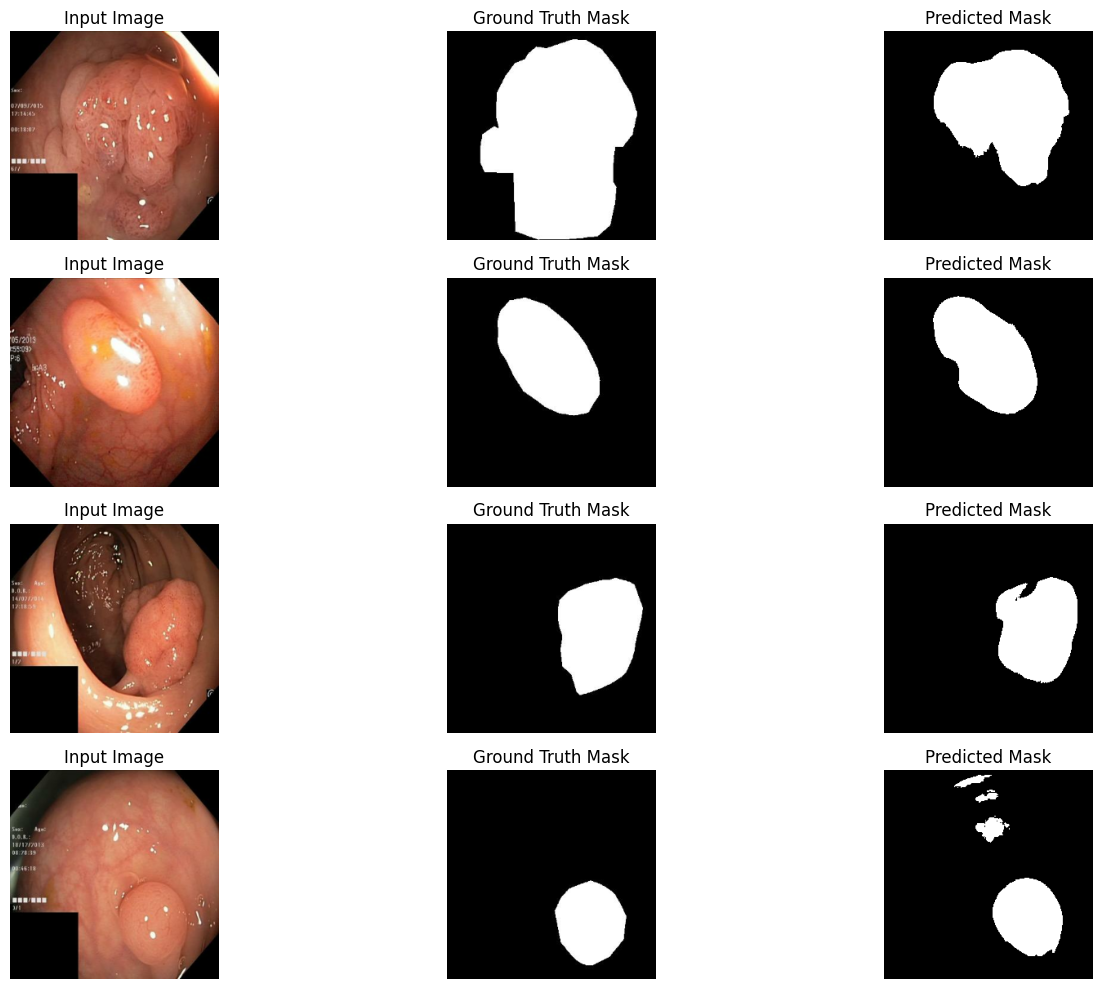

In [ ]:
# Get a batch of images and ground truth masks
test_iterator = iter(test_dataset)
batch = next(test_iterator)

images = batch[0]  # Input images
ground_truth_masks = batch[1]  # Ground truth masks

# Generate predictions
predicted_masks = model.predict(images)

# Post-process predictions (e.g., threshold for binary masks)
predicted_masks = (predicted_masks > 0.5).astype("float32")  # Thresholding at 0.5

import matplotlib.pyplot as plt

# Select a few samples to visualize
num_samples = min(5, len(images))
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(images[i], cmap='gray')  # Display input image
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(ground_truth_masks[i], cmap='gray')  # Display ground truth mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(predicted_masks[i], cmap='gray')  # Display predicted mask
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


##DeepLabv3

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Epoch 1/200


Training loss: 0.4644
Epoch 2/200


Training loss: 0.3415


Validation loss: 0.2980
Validation Mean Dice Score (IoU): 0.1906
Epoch 3/200


Training loss: 0.2827
Epoch 4/200


Training loss: 0.2338


Validation loss: 0.2045
Validation Mean Dice Score (IoU): 0.1517
Epoch 5/200


Training loss: 0.2047
Epoch 6/200


Training loss: 0.1793


Validation loss: 0.2031
Validation Mean Dice Score (IoU): 0.3216
Epoch 7/200


Training loss: 0.1706
Epoch 8/200


Training loss: 0.1650


Validation loss: 0.1935
Validation Mean Dice Score (IoU): 0.4607
Epoch 9/200


Training loss: 0.1602
Epoch 10/200


Training loss: 0.1513


Validation loss: 0.1860
Validation Mean Dice Score (IoU): 0.6570
Epoch 11/200


Training loss: 0.1510
Epoch 12/200


Training loss: 0.1489


Validation loss: 0.1771
Validation Mean Dice Score (IoU): 0.5499
Epoch 13/200


Training loss: 0.1464
Epoch 14/200


Training loss: 0.1422


Validation loss: 0.1731
Validation Mean Dice Score (IoU): 0.3733
Epoch 15/200


Training loss: 0.1350
Epoch 16/200


Training loss: 0.1382


Validation loss: 0.1800
Validation Mean Dice Score (IoU): 0.3157
Epoch 17/200


Training loss: 0.1257
Epoch 18/200


Training loss: 0.1236


Validation loss: 0.1594
Validation Mean Dice Score (IoU): 0.4118
Epoch 19/200


Training loss: 0.1451
Epoch 20/200


Training loss: 0.1371


Validation loss: 0.1628
Validation Mean Dice Score (IoU): 0.6901
Epoch 21/200


Training loss: 0.1313
Epoch 22/200


Training loss: 0.1187


Validation loss: 0.1632
Validation Mean Dice Score (IoU): 0.4908
Epoch 23/200


Training loss: 0.1198
Epoch 24/200


Training loss: 0.1194


Validation loss: 0.1510
Validation Mean Dice Score (IoU): 0.6541
Epoch 25/200


Training loss: 0.1197
Epoch 26/200


Training loss: 0.1163


Validation loss: 0.1618
Validation Mean Dice Score (IoU): 0.6884
Epoch 27/200


Training loss: 0.1131
Epoch 28/200


Training loss: 0.1163


Validation loss: 0.1507
Validation Mean Dice Score (IoU): 0.6098
Epoch 29/200


Training loss: 0.1110
Epoch 30/200


Training loss: 0.1117


Validation loss: 0.1564
Validation Mean Dice Score (IoU): 0.6576
Epoch 31/200


Training loss: 0.1081
Epoch 32/200


Training loss: 0.1198


Validation loss: 0.1432
Validation Mean Dice Score (IoU): 0.6084
Epoch 33/200


Training loss: 0.1193
Epoch 34/200


Training loss: 0.1078


Validation loss: 0.1728
Validation Mean Dice Score (IoU): 0.5983
Epoch 35/200


Training loss: 0.1086
Epoch 36/200


Training loss: 0.1059


Validation loss: 0.1385
Validation Mean Dice Score (IoU): 0.6516
Epoch 37/200


Training loss: 0.1029
Epoch 38/200


Training loss: 0.0972


Validation loss: 0.1430
Validation Mean Dice Score (IoU): 0.6749
Epoch 39/200


Training loss: 0.0974
Epoch 40/200


Training loss: 0.0939


Validation loss: 0.1581
Validation Mean Dice Score (IoU): 0.6028
Epoch 41/200


Training loss: 0.1033
Epoch 42/200


Training loss: 0.1177


Validation loss: 0.1486
Validation Mean Dice Score (IoU): 0.7389
Epoch 43/200


Training loss: 0.1179
Epoch 44/200


Training loss: 0.1121


Validation loss: 0.1522
Validation Mean Dice Score (IoU): 0.7327
Epoch 45/200


Training loss: 0.1026
Epoch 46/200


Training loss: 0.1081


Validation loss: 0.1763
Validation Mean Dice Score (IoU): 0.6904
Epoch 47/200


Training loss: 0.1030
Epoch 48/200


Training loss: 0.1034


Validation loss: 0.1506
Validation Mean Dice Score (IoU): 0.7446
Epoch 49/200


Training loss: 0.0930
Epoch 50/200


Training loss: 0.0929


Validation loss: 0.1382
Validation Mean Dice Score (IoU): 0.7020
Epoch 51/200


Training loss: 0.0891
Epoch 52/200


Training loss: 0.0879


Validation loss: 0.1327
Validation Mean Dice Score (IoU): 0.7211
Epoch 53/200


Training loss: 0.0889
Epoch 54/200


Training loss: 0.0872


Validation loss: 0.1296
Validation Mean Dice Score (IoU): 0.7116
Epoch 55/200


Training loss: 0.0880
Epoch 56/200


Training loss: 0.0857


Validation loss: 0.1281
Validation Mean Dice Score (IoU): 0.7216
Epoch 57/200


Training loss: 0.0817
Epoch 58/200


Training loss: 0.0812


Validation loss: 0.1267
Validation Mean Dice Score (IoU): 0.7462
Epoch 59/200


Training loss: 0.0823
Epoch 60/200


Training loss: 0.0841


Validation loss: 0.1256
Validation Mean Dice Score (IoU): 0.7272
Epoch 61/200


Training loss: 0.0842
Epoch 62/200


Training loss: 0.0815


Validation loss: 0.1257
Validation Mean Dice Score (IoU): 0.7436
Epoch 63/200


Training loss: 0.0795
Epoch 64/200


Training loss: 0.0822


Validation loss: 0.1366
Validation Mean Dice Score (IoU): 0.7535
Epoch 65/200


Training loss: 0.0831
Epoch 66/200


Training loss: 0.0803


Validation loss: 0.1311
Validation Mean Dice Score (IoU): 0.7265
Epoch 67/200


Training loss: 0.0791
Epoch 68/200


Training loss: 0.0797


Validation loss: 0.1205
Validation Mean Dice Score (IoU): 0.7412
Epoch 69/200


Training loss: 0.0813
Epoch 70/200


Training loss: 0.0784


Validation loss: 0.1232
Validation Mean Dice Score (IoU): 0.7285
Epoch 71/200


Training loss: 0.0747
Epoch 72/200


Training loss: 0.0790


Validation loss: 0.1276
Validation Mean Dice Score (IoU): 0.7378
Epoch 73/200


Training loss: 0.0767
Epoch 74/200


Training loss: 0.0777


Validation loss: 0.1263
Validation Mean Dice Score (IoU): 0.7172
Epoch 75/200


Training loss: 0.0779
Epoch 76/200


Training loss: 0.0767


Validation loss: 0.1205
Validation Mean Dice Score (IoU): 0.7387
Epoch 77/200


Training loss: 0.0767
Epoch 78/200


Training loss: 0.0784


Validation loss: 0.1210
Validation Mean Dice Score (IoU): 0.7078
Epoch 79/200


Training loss: 0.0765
Epoch 80/200


Training loss: 0.0770


Validation loss: 0.1165
Validation Mean Dice Score (IoU): 0.7218
Epoch 81/200


Training loss: 0.0780
Epoch 82/200


Training loss: 0.0752


Validation loss: 0.1258
Validation Mean Dice Score (IoU): 0.7168
Epoch 83/200


Training loss: 0.0741
Epoch 84/200


Training loss: 0.0747


Validation loss: 0.1237
Validation Mean Dice Score (IoU): 0.7098
Epoch 85/200


Training loss: 0.0750
Epoch 86/200


Training loss: 0.0766


Validation loss: 0.1237
Validation Mean Dice Score (IoU): 0.7445
Epoch 87/200


Training loss: 0.0751
Epoch 88/200


Training loss: 0.0754


Validation loss: 0.1238
Validation Mean Dice Score (IoU): 0.7316
Epoch 89/200


Training loss: 0.0745
Epoch 90/200


Training loss: 0.0737


Validation loss: 0.1244
Validation Mean Dice Score (IoU): 0.7383
Epoch 91/200


Training loss: 0.0760
Epoch 92/200


Training loss: 0.0756


Validation loss: 0.1312
Validation Mean Dice Score (IoU): 0.7380
Epoch 93/200


Training loss: 0.0739
Epoch 94/200


Training loss: 0.0717


Validation loss: 0.1328
Validation Mean Dice Score (IoU): 0.7327
Epoch 95/200


Training loss: 0.0728
Epoch 96/200


Training loss: 0.0750


Validation loss: 0.1276
Validation Mean Dice Score (IoU): 0.7231
Epoch 97/200


Training loss: 0.0737
Epoch 98/200


Training loss: 0.0714


Validation loss: 0.1262
Validation Mean Dice Score (IoU): 0.7197
Epoch 99/200


Training loss: 0.0741
Epoch 100/200


Training loss: 0.0736


Validation loss: 0.1248
Validation Mean Dice Score (IoU): 0.7277
Epoch 101/200


Training loss: 0.0717
Epoch 102/200


Training loss: 0.0721


Validation loss: 0.1309
Validation Mean Dice Score (IoU): 0.7238
Epoch 103/200


Training loss: 0.0725
Epoch 104/200


Training loss: 0.0726


Validation loss: 0.1285
Validation Mean Dice Score (IoU): 0.7273
Epoch 105/200


Training loss: 0.0706
Epoch 106/200


Training loss: 0.0717


Validation loss: 0.1312
Validation Mean Dice Score (IoU): 0.7148
Epoch 107/200


Training loss: 0.0719
Epoch 108/200


Training loss: 0.0720


Validation loss: 0.1334
Validation Mean Dice Score (IoU): 0.7261
Epoch 109/200


Training loss: 0.0721
Epoch 110/200


Training loss: 0.0713


Validation loss: 0.1281
Validation Mean Dice Score (IoU): 0.7450
Epoch 111/200


Training loss: 0.0728
Epoch 112/200


Training loss: 0.0731


Validation loss: 0.1285
Validation Mean Dice Score (IoU): 0.7321
Epoch 113/200


Training loss: 0.0728
Epoch 114/200


Training loss: 0.0726


Validation loss: 0.1301
Validation Mean Dice Score (IoU): 0.7308
Epoch 115/200


Training loss: 0.0714
Epoch 116/200


Training loss: 0.0702


Validation loss: 0.1270
Validation Mean Dice Score (IoU): 0.7253
Epoch 117/200


Training loss: 0.0714
Epoch 118/200


Training loss: 0.0712


Validation loss: 0.1259
Validation Mean Dice Score (IoU): 0.7212
Epoch 119/200


Training loss: 0.0726
Epoch 120/200


Training loss: 0.0735


Validation loss: 0.1275
Validation Mean Dice Score (IoU): 0.7241
Epoch 121/200


Training loss: 0.0720
Epoch 122/200


Training loss: 0.0733


Validation loss: 0.1257
Validation Mean Dice Score (IoU): 0.7152
Epoch 123/200


Training loss: 0.0702
Epoch 124/200


Training loss: 0.0708


Validation loss: 0.1312
Validation Mean Dice Score (IoU): 0.7045
Epoch 125/200


Training loss: 0.0727
Epoch 126/200


Training loss: 0.0721


Validation loss: 0.1329
Validation Mean Dice Score (IoU): 0.7076
Epoch 127/200


Training loss: 0.0729
Epoch 128/200


Training loss: 0.0712


Validation loss: 0.1262
Validation Mean Dice Score (IoU): 0.7292
Epoch 129/200


Training loss: 0.0729
Epoch 130/200


Training loss: 0.0730


Validation loss: 0.1248
Validation Mean Dice Score (IoU): 0.7340
Epoch 131/200


Training loss: 0.0707
Epoch 132/200


Training loss: 0.0719


Validation loss: 0.1231
Validation Mean Dice Score (IoU): 0.7204
Epoch 133/200


Training loss: 0.0717
Epoch 134/200


Training loss: 0.0721


Validation loss: 0.1263
Validation Mean Dice Score (IoU): 0.7168
Epoch 135/200


Training loss: 0.0712
Epoch 136/200


Training loss: 0.0710


Validation loss: 0.1336
Validation Mean Dice Score (IoU): 0.7313
Epoch 137/200


Training loss: 0.0707
Epoch 138/200


Training loss: 0.0724


Validation loss: 0.1328
Validation Mean Dice Score (IoU): 0.7214
Epoch 139/200


Training loss: 0.0728
Epoch 140/200


Training loss: 0.0706


Validation loss: 0.1254
Validation Mean Dice Score (IoU): 0.7167
Epoch 141/200


Training loss: 0.0708
Epoch 142/200


Training loss: 0.0734


Validation loss: 0.1266
Validation Mean Dice Score (IoU): 0.7325
Epoch 143/200


Training loss: 0.0728
Epoch 144/200


Training loss: 0.0735


Validation loss: 0.1260
Validation Mean Dice Score (IoU): 0.7226
Epoch 145/200


Training loss: 0.0722
Epoch 146/200


Training loss: 0.0729


Validation loss: 0.1283
Validation Mean Dice Score (IoU): 0.7404
Epoch 147/200


Training loss: 0.0713
Epoch 148/200


Training loss: 0.0727


Validation loss: 0.1295
Validation Mean Dice Score (IoU): 0.7136
Epoch 149/200


Training loss: 0.0727
Epoch 150/200


Training loss: 0.0721


Validation loss: 0.1291
Validation Mean Dice Score (IoU): 0.7159
Epoch 151/200


Training loss: 0.0729
Epoch 152/200


Training loss: 0.0708


Validation loss: 0.1299
Validation Mean Dice Score (IoU): 0.7388
Epoch 153/200


Training loss: 0.0731
Epoch 154/200


Training loss: 0.0713


Validation loss: 0.1253
Validation Mean Dice Score (IoU): 0.7178
Epoch 155/200


Training loss: 0.0718
Epoch 156/200


Training loss: 0.0734


Validation loss: 0.1277
Validation Mean Dice Score (IoU): 0.7274
Epoch 157/200


Training loss: 0.0717
Epoch 158/200


Training loss: 0.0706


Validation loss: 0.1271
Validation Mean Dice Score (IoU): 0.7242
Epoch 159/200


Training loss: 0.0714
Epoch 160/200


Training loss: 0.0734


Validation loss: 0.1262
Validation Mean Dice Score (IoU): 0.7271
Epoch 161/200


Training loss: 0.0727
Epoch 162/200


Training loss: 0.0725


Validation loss: 0.1256
Validation Mean Dice Score (IoU): 0.7363
Epoch 163/200


Training loss: 0.0710
Epoch 164/200


Training loss: 0.0716


Validation loss: 0.1264
Validation Mean Dice Score (IoU): 0.7105
Epoch 165/200


Training loss: 0.0727
Epoch 166/200


Training loss: 0.0710


Validation loss: 0.1320
Validation Mean Dice Score (IoU): 0.7121
Epoch 167/200


Training loss: 0.0744
Epoch 168/200


Training loss: 0.0724


Validation loss: 0.1259
Validation Mean Dice Score (IoU): 0.7257
Epoch 169/200


Training loss: 0.0720
Epoch 170/200


Training loss: 0.0730


Validation loss: 0.1252
Validation Mean Dice Score (IoU): 0.7355
Epoch 171/200


Training loss: 0.0740
Epoch 172/200


Training loss: 0.0726


Validation loss: 0.1347
Validation Mean Dice Score (IoU): 0.7412
Epoch 173/200


Training loss: 0.0707
Epoch 174/200


Training loss: 0.0732


Validation loss: 0.1233
Validation Mean Dice Score (IoU): 0.7248
Epoch 175/200


Training loss: 0.0726
Epoch 176/200


Training loss: 0.0740


Validation loss: 0.1251
Validation Mean Dice Score (IoU): 0.7178
Epoch 177/200


Training loss: 0.0723
Epoch 178/200


Training loss: 0.0733


Validation loss: 0.1278
Validation Mean Dice Score (IoU): 0.7176
Epoch 179/200


Training loss: 0.0713
Epoch 180/200


Training loss: 0.0710


Validation loss: 0.1290
Validation Mean Dice Score (IoU): 0.7323
Epoch 181/200


Training loss: 0.0729
Epoch 182/200


Training loss: 0.0720


Validation loss: 0.1285
Validation Mean Dice Score (IoU): 0.7219
Epoch 183/200


Training loss: 0.0733
Epoch 184/200


Training loss: 0.0718


Validation loss: 0.1286
Validation Mean Dice Score (IoU): 0.7167
Epoch 185/200


Training loss: 0.0739
Epoch 186/200


Training loss: 0.0713


Validation loss: 0.1308
Validation Mean Dice Score (IoU): 0.7469
Epoch 187/200


Training loss: 0.0729
Epoch 188/200


Training loss: 0.0718


Validation loss: 0.1282
Validation Mean Dice Score (IoU): 0.7280
Epoch 189/200


Training loss: 0.0727
Epoch 190/200


Training loss: 0.0716


Validation loss: 0.1275
Validation Mean Dice Score (IoU): 0.7146
Epoch 191/200


Training loss: 0.0721
Epoch 192/200


Training loss: 0.0712


Validation loss: 0.1237
Validation Mean Dice Score (IoU): 0.7221
Epoch 193/200


Training loss: 0.0723
Epoch 194/200


Training loss: 0.0724


Validation loss: 0.1305
Validation Mean Dice Score (IoU): 0.7252
Epoch 195/200


Training loss: 0.0720
Epoch 196/200


Training loss: 0.0703


Validation loss: 0.1254
Validation Mean Dice Score (IoU): 0.7365
Epoch 197/200


Training loss: 0.0694
Epoch 198/200


Training loss: 0.0746


Validation loss: 0.1354
Validation Mean Dice Score (IoU): 0.7269
Epoch 199/200


Training loss: 0.0717
Epoch 200/200


Training loss: 0.0726


Validation loss: 0.1321
Validation Mean Dice Score (IoU): 0.7457
Model saved to /content/drive/MyDrive/deplo_dataset/deeplabv3/deeplabv3_256.pth


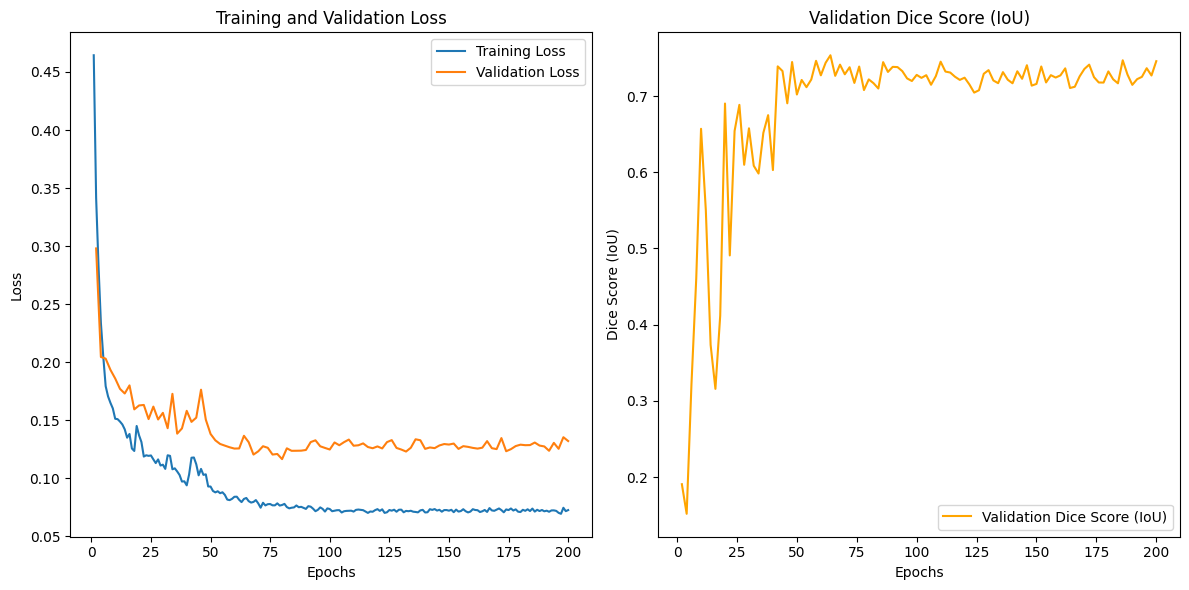

Training complete!


In [ ]:
deeplab_model = deeplabv3_resnet50(weights=None, num_classes=1)
model = deeplab_model
model = model.to(device)
model_save_dir = "/content/drive/MyDrive/deplo_dataset/deeplabv3"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
model_save_path = os.path.join(model_save_dir, "deeplabv3_256.pth")

loss_function = DiceLoss(sigmoid=True)
# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Dice Metric for evaluation
dice_metric = DiceMetric(include_background=False, reduction="mean")

num_epochs=200

trainingdeeplab(model, model_save_dir, model_save_path,train_loader, val_loader, device)

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, data_loader, device, num_samples=5):
    """
    Visualize predictions from the model alongside ground truth masks.

    Parameters:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset (e.g., validation or test loader).
        device: Device to perform inference (CPU/GPU).
        num_samples: Number of samples to visualize.
    """
    model.eval()  # Set the model to evaluation mode
    samples_shown = 0  # Counter for the number of samples visualized

    with torch.no_grad():
        for batch_data in data_loader:
            images = batch_data["image"].to(device)
            masks = batch_data["mask"].to(device)

            # Get predictions from the model
            outputs = model(images)["out"]  # Extract the actual output tensor
            outputs = torch.sigmoid(outputs)  # Apply sigmoid to convert to probabilities

            # Loop through each sample in the batch
            for i in range(images.shape[0]):
                if samples_shown >= num_samples:
                    return  # Stop once the required number of samples is shown

                # Get the data for the current sample
                image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
                mask = masks[i].cpu().numpy()[0]  # Ground truth mask
                prediction = outputs[i].cpu().numpy()[0]  # Model prediction

                # Plot the original image, ground truth mask, and prediction
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image, cmap="gray" if image.shape[2] == 1 else None)
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap="gray")
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(prediction, cmap="gray")
                plt.title("Model Prediction")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                samples_shown += 1


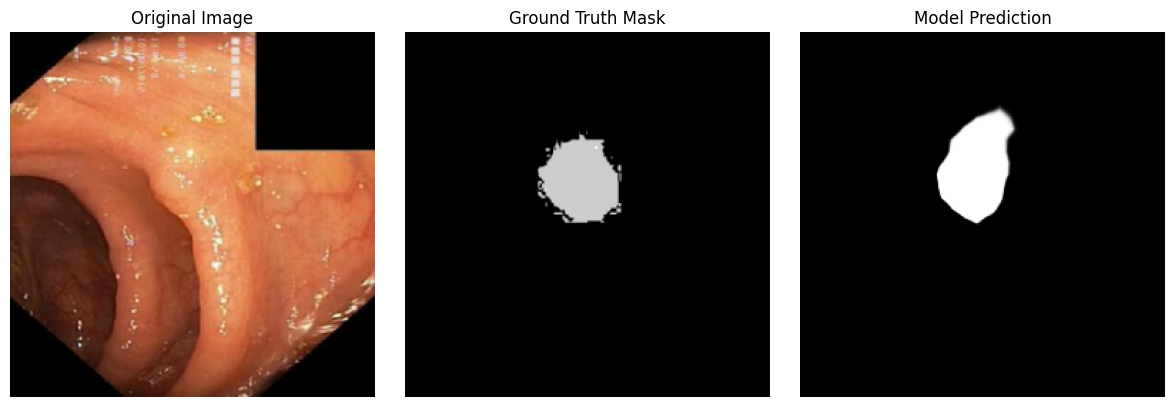

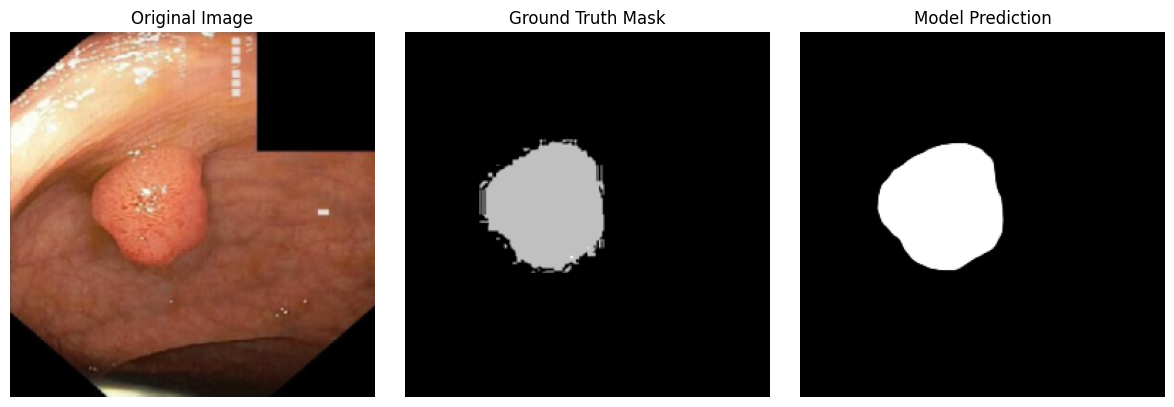

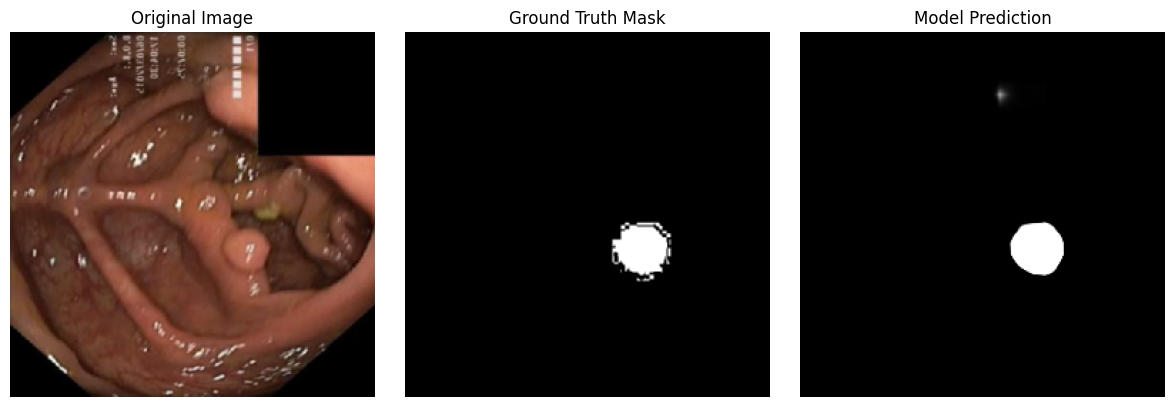

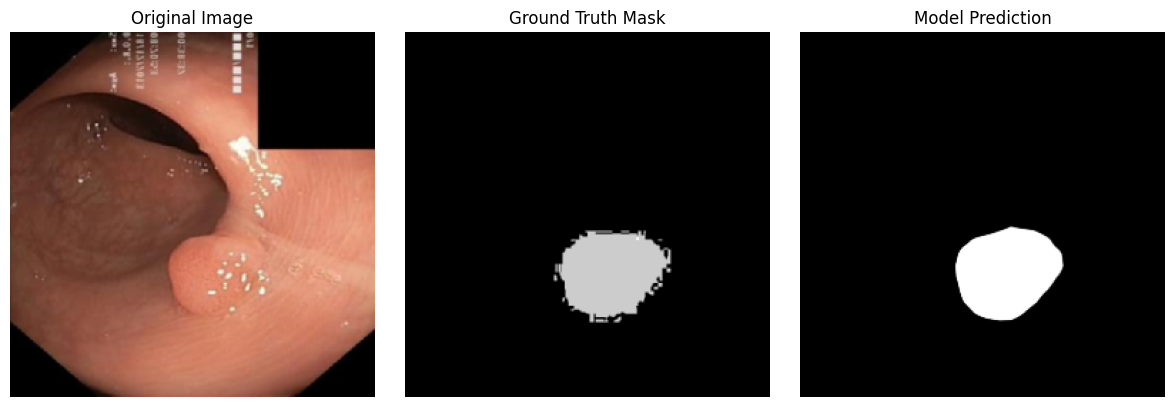

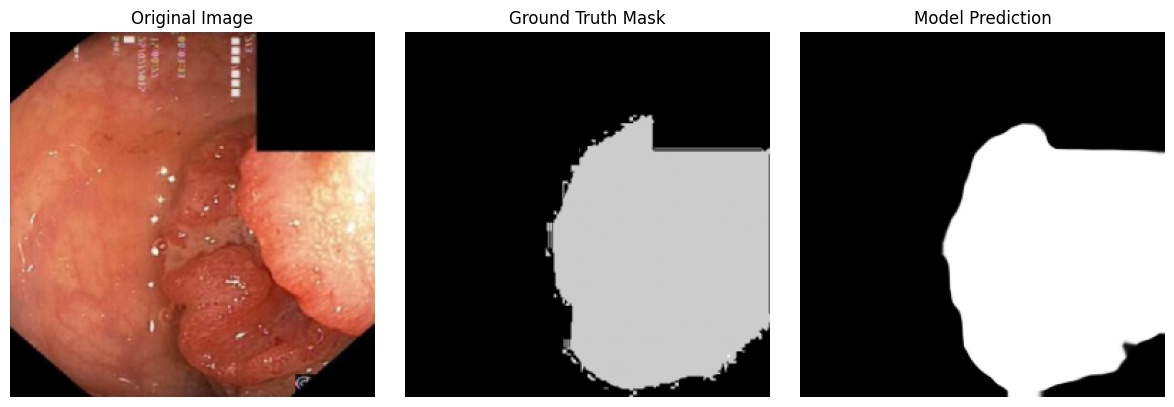

In [ ]:
visualize_predictions(model, val_loader, device, num_samples=5)

In [ ]:
def test_model_deeplab(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data in dataloader:
            images = batch_data["image"].to(device)  # Move image tensor to device
            masks = batch_data["mask"].to(device)  # Move mask tensor to device

            # Forward pass through the model
            outputs = model(images)["out"]  # Extract the 'out' key from the output dictionary

            # Convert outputs to binary masks (0 or 1)
            predicted_masks = torch.sigmoid(outputs)
            predicted_masks = (predicted_masks > 0.5).float()  # Threshold to create binary masks

            # Collect predictions and ground truths for metrics calculation
            all_preds.append(predicted_masks.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

    # Flatten the list of arrays
    all_preds = np.concatenate(all_preds, axis=0).flatten().astype(int)
    all_labels = np.concatenate(all_labels, axis=0).flatten().astype(int)

    # Calculate IoU
    ious = [calculate_iou(pred, true) for pred, true in zip(all_preds.reshape(-1, 1), all_labels.reshape(-1, 1))]
    avg_iou = np.mean(ious)
    print(f"Test Average IoU: {avg_iou:.4f}")

    # Calculate additional metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)  # Avoid division by zero
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plot_confusion_matrix(cm)

    return avg_iou, accuracy, precision, recall, f1, cm


<ipython-input-22-b0a3004b4d56>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Average IoU: 0.1529
Test Accuracy: 0.9749
Test Precision: 0.9152
Test Recall: 0.9332
Test F1 Score: 0.9241
Confusion Matrix:
[[5387295   92830]
 [  71682 1001793]]


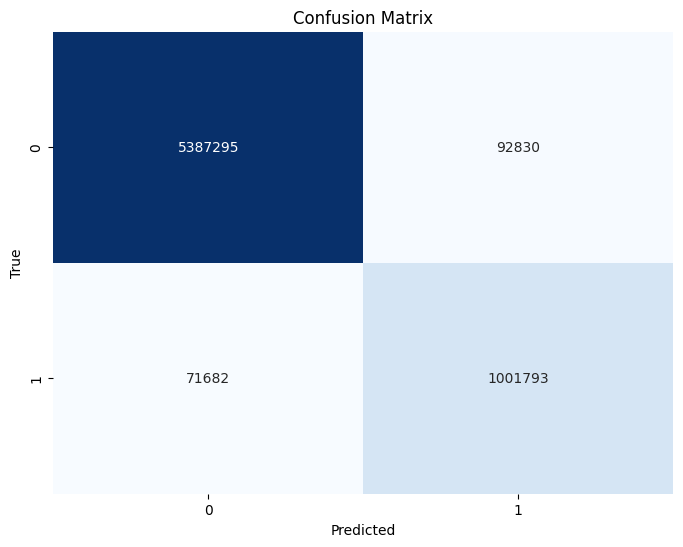

In [ ]:
model = deeplab_model
weight_path = os.path.join(model_save_dir,model_save_path)
model.load_state_dict(torch.load(weight_path))
model = model.to(device)
#batch_size=16

# Test the model
test_metrics = test_model_deeplab(model, test_loader, device)

In [ ]:
!python --version

Python 3.11.11
